In [1]:
:ext TypeSynonymInstances
:ext FlexibleInstances
:ext LambdaCase

In [2]:
import Utils
import Data.Tuple.Extra (uncurry3, both, first, second, (***))
import Data.Bool (bool)
import Data.List.Extra (sortOn, dropEnd, enumerate, maximumOn)
import Data.Ord (Down(..), comparing)
import Data.Function (on, (&))
import Data.Maybe (fromJust)
import Control.Monad (replicateM, forM, forM_)
import Control.Monad.Trans.State
import Control.Monad.Trans.Class (lift)
import Data.IORef
import qualified Data.Map as Map

In [3]:
import Tyche.Model
import Tyche.Dist
import Tyche.Prelude
import Tyche.Prob
import Tyche.Inference.Enumerate
import qualified System.Random.MWC.Probability as MWC
-- import Tyche.Inference.LikelihoodWeighting

In [4]:
import Graphics.Vega.VegaLite hiding (filter, lookup, repeat, FontWeight(Normal))
import qualified Graphics.Vega.VegaLite as VL (filter, lookup, repeat, FontWeight(Normal))

# Setting Things Up

## The Model

Worlds are distinguished only by the heights of the individuals at issue

In [5]:
data E = John | Mary | Fred deriving (Eq, Enum, Show, Bounded)

domain :: [E]
domain = enumerate

data World = World {label :: String, ht :: E -> Int}

instance Eq World where
  w == w' = show w == show w'
  
instance Ord World where
  compare = comparing (\s -> map (ht s) domain)

instance Show World where
  show (World l _) = l

But what we reason about are effectively **pointed distributions**, which include information about individuals' heights *relative to other heights of individuals*

In [6]:
type Index = (World, Int)
instance {-# OVERLAPPING #-} Show Index where
  show (w,i) = show w ++ ";" ++ show i

A **proposition** is a set of these centered distributions

In [7]:
type Prop = [Index]

For the sake of computational efficiency, we imagine that there are only 11 possible heights

In [8]:
mkWorld :: (Int, Int, Int) -> World
mkWorld (d, d', d'') = World ("j" ++ show d ++ "m" ++ show d' ++ "f" ++ show d'') hts
  where hts = \case {John -> d; Mary -> d'; _ -> d''}
  
heights = [2 .. 10]
universe = [mkWorld (h, h', h'') | h <- heights, h' <- heights, h'' <- heights]

Again for efficiency's sake, not all world-center pairs are considered possible. The median height is assumed to fall between $5$ and $7$, and everyone's height is assumed to fall within $2$ steps of the median: 

\begin{equation} C = \bigcap_{x\in D_e} \Bigl\{\langle w, \mu\rangle \Bigm\vert 5 \leq \mu \leq 7,\ -2 \leq \mu - \textsf{ht}_{w}(x) \leq 2\Bigr\} \end{equation}

In [9]:
sigma = 3
indices = [(w, mu) | mu <- drop sigma . dropEnd sigma $ heights, w <- universe, all (\x -> abs (ht w x - mu) <= sigma) domain]
-- indices

## The Language

We have a marked utterance, an unmarked utterance, and a null utterance (the least marked)

In [10]:
data Utt = UNone | UTall | UShrt
  deriving (Eq, Show, Ord, Enum, Bounded)

utterances = enumerate

A **lexicon** is a denotation function mapping utterances to propositions

In [11]:
data Lexicon = Lex {lexID :: Int, den :: Utt -> Prop}
instance Show Lexicon where
  show (Lex _ f) = "C = " ++ show (f UNone) ++ "; E = " ++ show (f UTall)
instance Eq Lexicon where
  (Lex m _) == (Lex n _) = m == n
instance Ord Lexicon where
  (Lex m _) <= (Lex n _) = m <= n

## Rational Agents

In [12]:
-- Initialize reference cell for storing results to speed up computations
type Cache = IORef (Int, Map.Map (Int, Utt, Lexicon) (Dist Index))
cacheRef <- newIORef (0, Map.empty) :: IO Cache

An $n$-level agent reasoning about `a` given `k` is a graphical model (supplemented with a memory, for efficiency)
- if the problem is old, the posterior distribution is returned from memory
- if the problem is new, then priors over indices, messages, and lexica are fed to a node computing the posterior distribution over `a`

In [13]:
data Priors = Priors {ip :: Model Index, up :: Model Utt, lp :: Model Lexicon}
type Agent k a = Priors -> Cache -> (Int, k, Lexicon) -> Model a
type AgentPlain k a = Priors -> (Int, k, Lexicon) -> Model a

* A speaker trying to describe index $i$ is an agent that chooses an utterance $u$ in proportion to its prior probability (its cost) and the likelihood that a listener would assign to $i$ upon hearing $u$
* A listener trying to interpret an utterance $u$ is an agent that chooses an index $i$ in proportion to its prior probability and the likelihood that a speaker would assign to $u$ upon trying to describe $i$

In [14]:
alpha :: Double
alpha = 4

speaker :: Agent Index Utt
speaker priors ref (n,i,l) =
  do u <- up priors
     if null (den l u)
       then weight negInf
       else do lnr <- lift $ memoize ref (fmap fst . listener priors ref) (n-1,u,l)
               weight $ alpha * logProb lnr i
     return u

listener :: Agent Utt (Index, Lexicon)
listener priors ref (n,u,l)
  | n > 0 =
      do index  <- ip priors
         interp <- if n == 1 then lp priors else return l
         spr    <- lift . enumD $ speaker priors ref (n,index,interp)
         observe spr u
         return (index, interp)
  | otherwise =
      do index  <- ip priors
         condition (index `elem` den l u)
         return (index, l)

In [15]:
{--
speakerPlain :: AgentPlain Index Utt
speakerPlain priors (n,i,l) =
  do u   <- up priors
     lnr <- lift $ enumD $ listenerPlain priors (n-1,u,l)
     weight $ alpha * logProb lnr i
     return u

listenerPlain :: AgentPlain Utt Index
listenerPlain priors (n,u,l)
  | n > 0 =
      do index  <- ip priors
         interp <- if n == 1 then lp priors else return l
         spr    <- lift . enumD $ speakerPlain priors (n,index,interp)
         observe spr u
         return index
  | otherwise =
      do index <- ip priors
         condition (index `elem` den l u)
         return index
--}

# Priors

Prior belief about indices is that people are normally sized. That is, the median height is unknown, but whatever it is, it is more likely that John and Mary are close to that height than that they are far away from it. Their respective heights are considered statistically independent.

In [16]:
indicesPriorFlat :: Model Index
indicesPriorFlat =
  do (w,i) <- unif indices
     forM_ domain $ \x ->
       observe (Normal 0 1.85) (fromIntegral $ ht w x - i)
     return (w,i)

Here we only show the joint distribution of John's height and the median height. The distributions over others' heights are identical.

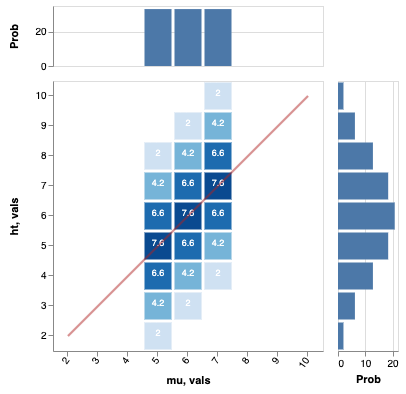

In [17]:
-- vlShow . sidewaysDists <$> forM domain (\x ->
--   titled (show x ++ "'s Height Prior") . barFromDist <$> enumD (($ x) . ht . fst <$> indicesPriorFlat)
--   )
vlShow . margHeatFromDist <$> enumD (first (`ht` John) <$> indicesPriorFlat)

Exogenous costs influence the prior likelihoods of utterances

In [18]:
cost :: Utt -> Double
cost UNone = 0
cost UTall = 1
cost UShrt = 2

utterancePrior1 :: Model Utt
utterancePrior1 = belief . fromList $ [(u, - alpha * cost u) | u <- utterances]

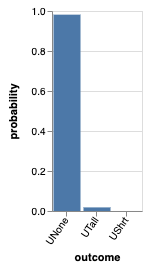

In [19]:
vlShow . barFromDist <$> enumD utterancePrior1

# Experiments

## All

### Positive Utterances

Keeping all priors about indices and utterances the same, we now model pragmatic listeners who consider various strengthenings of the assertion (note that these are strengthenings in the *dynamic sense*; the pure informational content about heights is the same in all lexica)

Baseline `allDen0` of both antonyms is that they are tautologies; everyone is within 3 steps of the median

On other interpretations, 'Tall' (resp. 'Short') places **all** of John, Mary, and Fred in a certain upper (resp. lower) percentile of the comparison class

\begin{align}
  [\![\text{John, Mary, and Fred are all tall}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \forall x.\,\textsf{ht}_w(x) \geq \mu + \sigma\\
  [\![\text{John, Mary, and Fred are all short}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \forall x.\,\textsf{ht}_w(x) \leq \mu + \sigma
\end{align}

In [20]:
allDen0 :: Lexicon
allDen0 = Lex 0 f
  where f _ = indices

posAllDens :: [Lexicon]
posAllDens =
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> all (\x -> ht w x >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> all (\x -> ht w x <= i + d) domain) indices
     return (Lex d f)

In [21]:
infoBaselineAll = Priors indicesPriorFlat utterancePrior1 (unif [allDen0])
infoLUMAll = infoBaselineAll {lp = unif posAllDens}

#### listener hears:

> "John, Mary, and Fred are all tall"

These agents become very confident that John's height is at least as high as the class standard, though they remain in the dark about what that standard is (the conclusions for others are identical)

And as seen in the `ht` marginal, even though the standard remains unknown, the belief that John's height meets or exceeds it leads to a (positively skewed) evaluative distribution over worlds

The resulting evaluative inference is small 

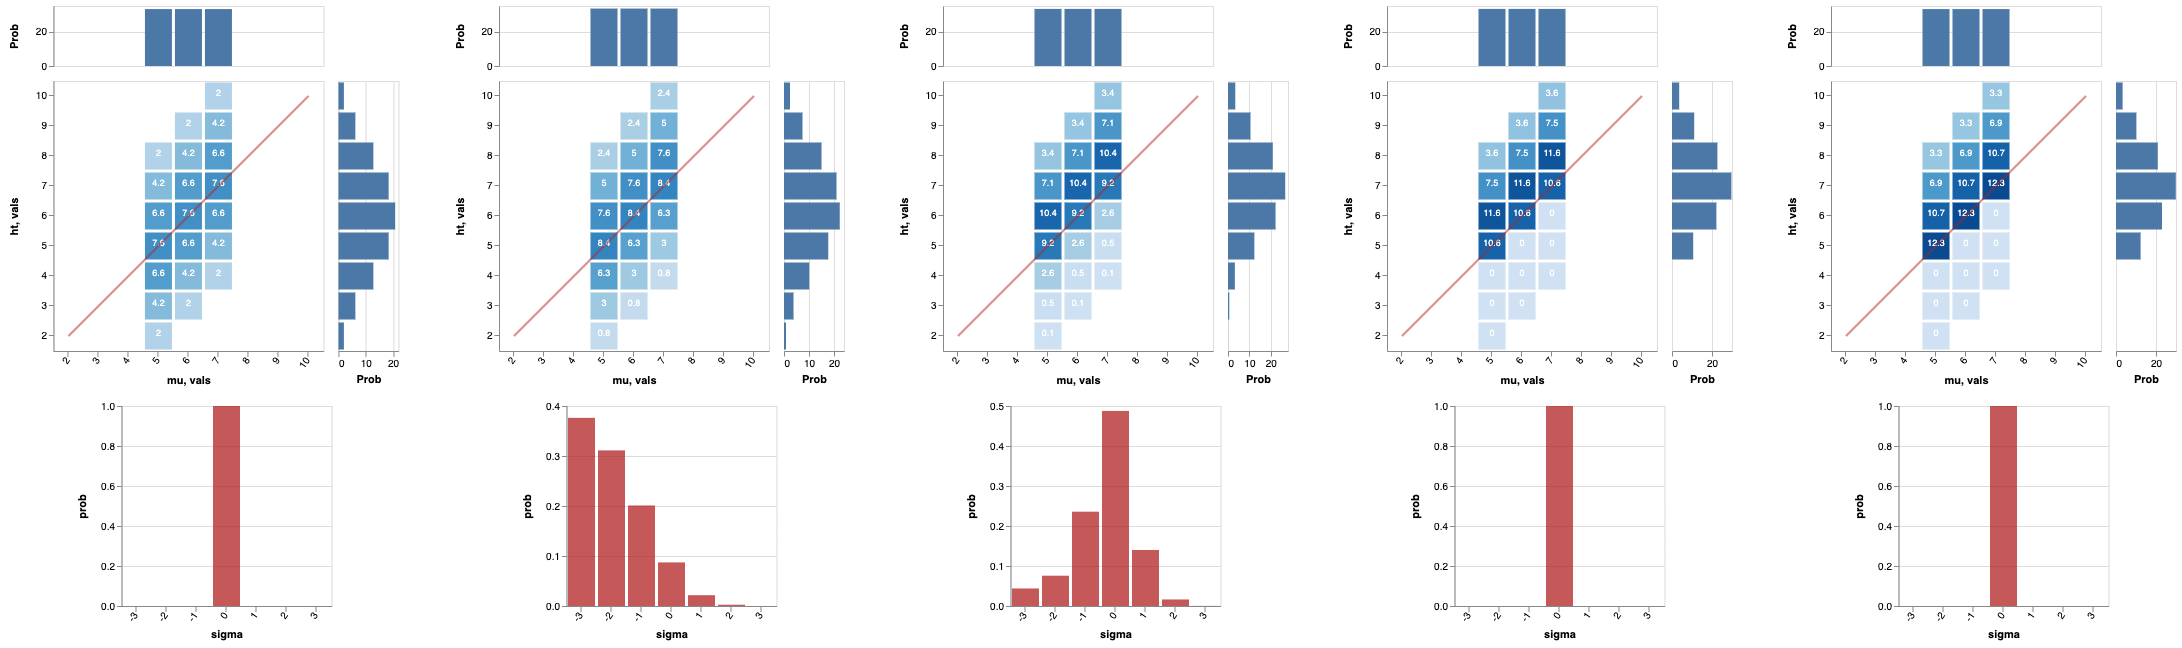

In [25]:
writeIORef cacheRef (0, Map.empty)

mkGraph m = do
  heat <- enumD (first (`ht` John) . fst <$> m)
  bar  <- enumD (lexID             . snd <$> m)
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (margHeatFromDist heat), fromVL (sdBarFromDist sigma bar)]
    ]

vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUMAll cacheRef (0, UTall, allDen0)
  , lp infoLUMAll >>= \l -> listener infoLUMAll cacheRef (0, UTall, l)
  , listener infoLUMAll cacheRef (1, UTall, allDen0)
  , listener infoLUMAll cacheRef (2, UTall, allDen0)
  , listener infoLUMAll cacheRef (3, UTall, allDen0)
  ]

(note that the red graphs are the estimated "threshold" for the adjective to apply, *not* the difference between John's estimated height and the estimated standard, though the latter relationship --- e.g., in level 1 listener's mind --- can be visualized with the following)

```
vlShow .  sdBarFromDist sigma <$> enumD ((\(w,i) -> ht w John - i) . fst <$> listener infoLUMAll cacheRef (1, UShrt, allDen0))
```

#### listener hears:

> "John, Mary, and Fred are all short"

These agents become quite certain that John's height falls below the class standard, though they remain in the dark about what that standard is (the conclusions for others are identical)

And as seen in the `ht` marginal, even though the standard remains unknown, the belief that John's height falls below it it leads to a (negatively skewed) evaluative distribution over worlds

The evaluativity effect is more pronounced than the positive case

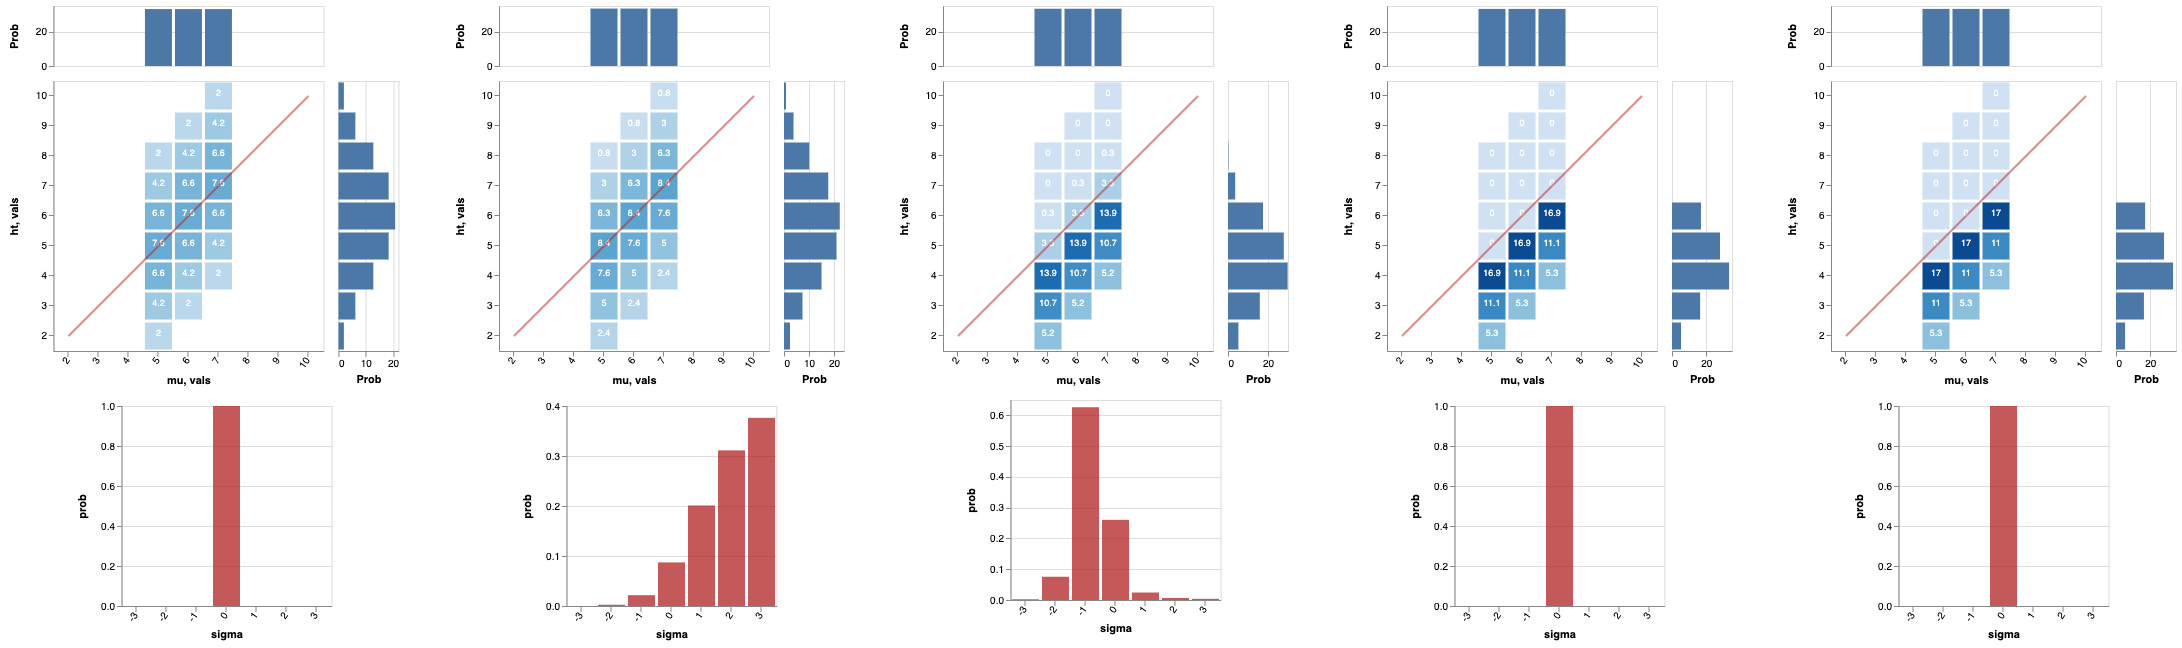

In [23]:
writeIORef cacheRef (0, Map.empty)
 
vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUMAll cacheRef (0, UShrt, allDen0)
  , lp infoLUMAll >>= \l -> listener infoLUMAll cacheRef (0, UShrt, l)
  , listener infoLUMAll cacheRef (1, UShrt, allDen0)
  , listener infoLUMAll cacheRef (2, UShrt, allDen0)
  , listener infoLUMAll cacheRef (3, UShrt, allDen0)
  ]

### Degree Demonstrative Utterances

All adjectival utterances are now interpreted as entailing that everyone's height is 6

In the baseline lexicon `allDenExact0`, this is all that is contributed by an utterance

Other interpretations place their heights at 6 and additionally guarantee that those heights are within a certain upper/lower percentile of the comparison class

\begin{align}
  [\![\text{John, Mary, and Fred are all 6-tall}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, 6 \geq \mu + \sigma \land \forall x.\,\textsf{ht}_w(x) \geq 6\\
  [\![\text{John, Mary, and Fred are all 6-short}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, 6 \leq \mu + \sigma \land \forall x.\,\textsf{ht}_w(x) \leq 6
\end{align}

In [26]:
allDenExact0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> all (\x -> ht w x >= 6) domain) indices
        f UShrt = filter (\(w,i) -> all (\x -> ht w x <= 6) domain) indices

exactAllDens :: [Lexicon]
exactAllDens = 
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> 6 >= i + d && all (\x -> ht w x >= 6) domain) indices
         f UShrt = filter (\(w,i) -> 6 <= i + d && all (\x -> ht w x <= 6) domain) indices
     return (Lex d f)

#### listener hears

> "Bill's height is 6; John, Mary, and Fred are that tall too"

Cutting to the chase, consider a listener that is not settled on one of these stengthenings

In [27]:
infoLUMAllExact = infoBaselineAll {lp = unif exactAllDens}

Of course since all of the lexica entail that everyone's height is 6, the distribution over worlds is completely determinate

The various conceivable strengthenings lead ultimately to a pragmatic conclusion that 6 is very probably normal for the height of someone in the comparison class (this was already guaranteed by the prior), but it's possible that 6 is relatively high compared to the median

In other words, if there is any evaluativity effect, it is very weak

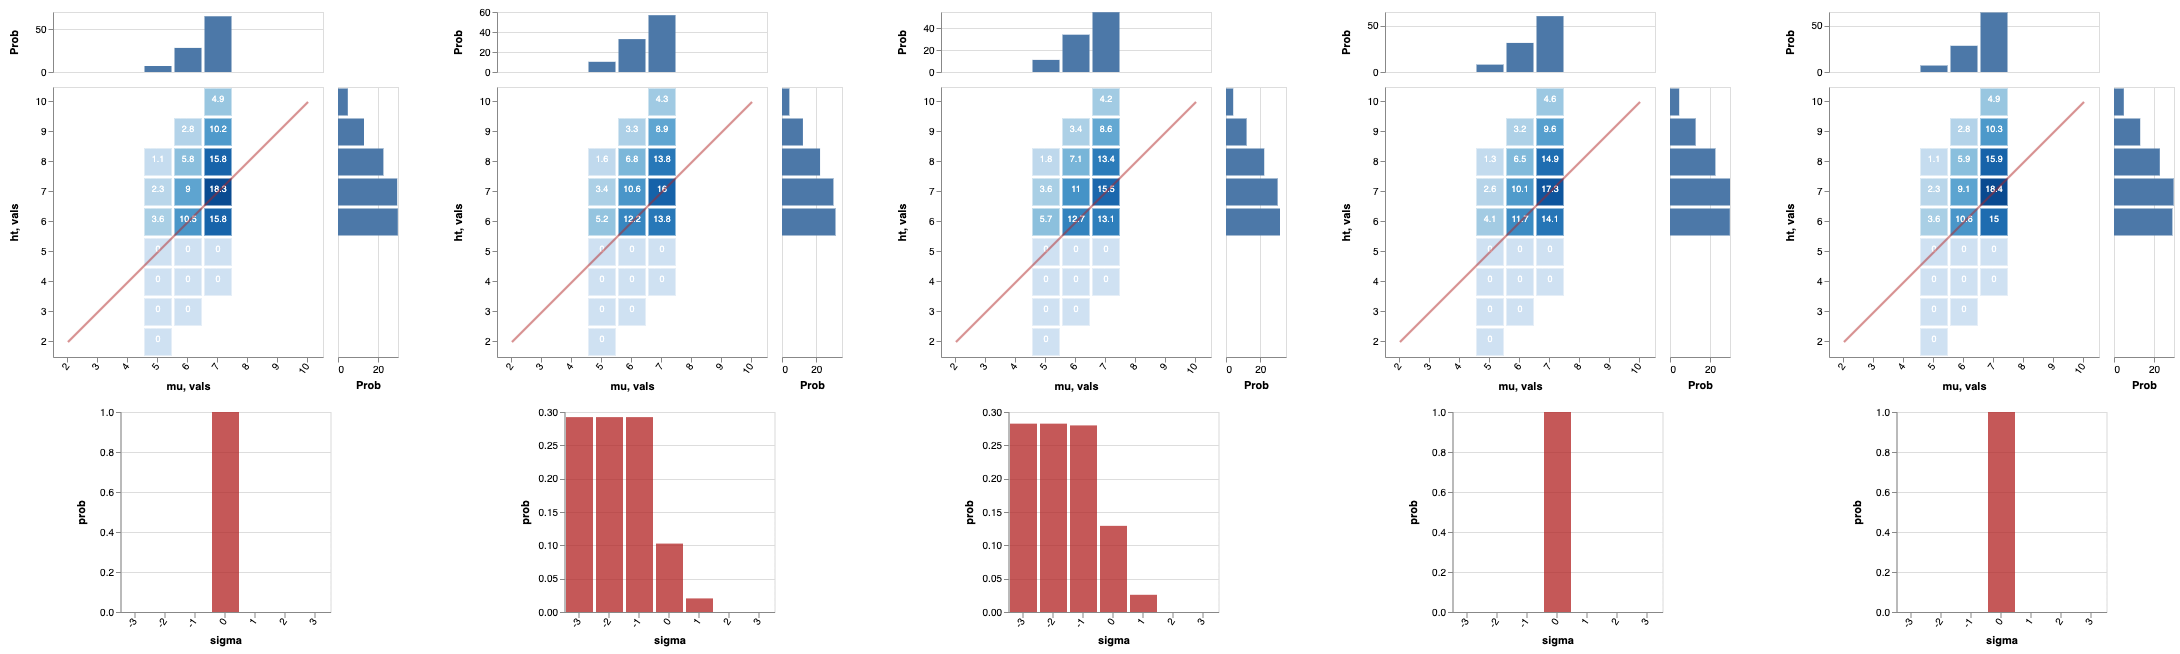

In [28]:
writeIORef cacheRef (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUMAllExact cacheRef (0, UTall, allDenExact0)
  , lp infoLUMAllExact >>= \l -> listener infoLUMAllExact cacheRef (0, UTall, l)
  , listener infoLUMAllExact cacheRef (1, UTall, allDenExact0)
  , listener infoLUMAllExact cacheRef (2, UTall, allDenExact0)
  , listener infoLUMAllExact cacheRef (3, UTall, allDenExact0)
  ]

#### listener hears:

> "Bill's height is 6; John, Mary, and Fred are that short too"

Again, since the lexica all entail that a "6-short person" has height 6, the distribution over worlds is certain

But now, the various strengthenings lead ultimately to a pragmatic conclusion that 6 is almost certainly below what's normal

The evaluativity effect here is much stronger

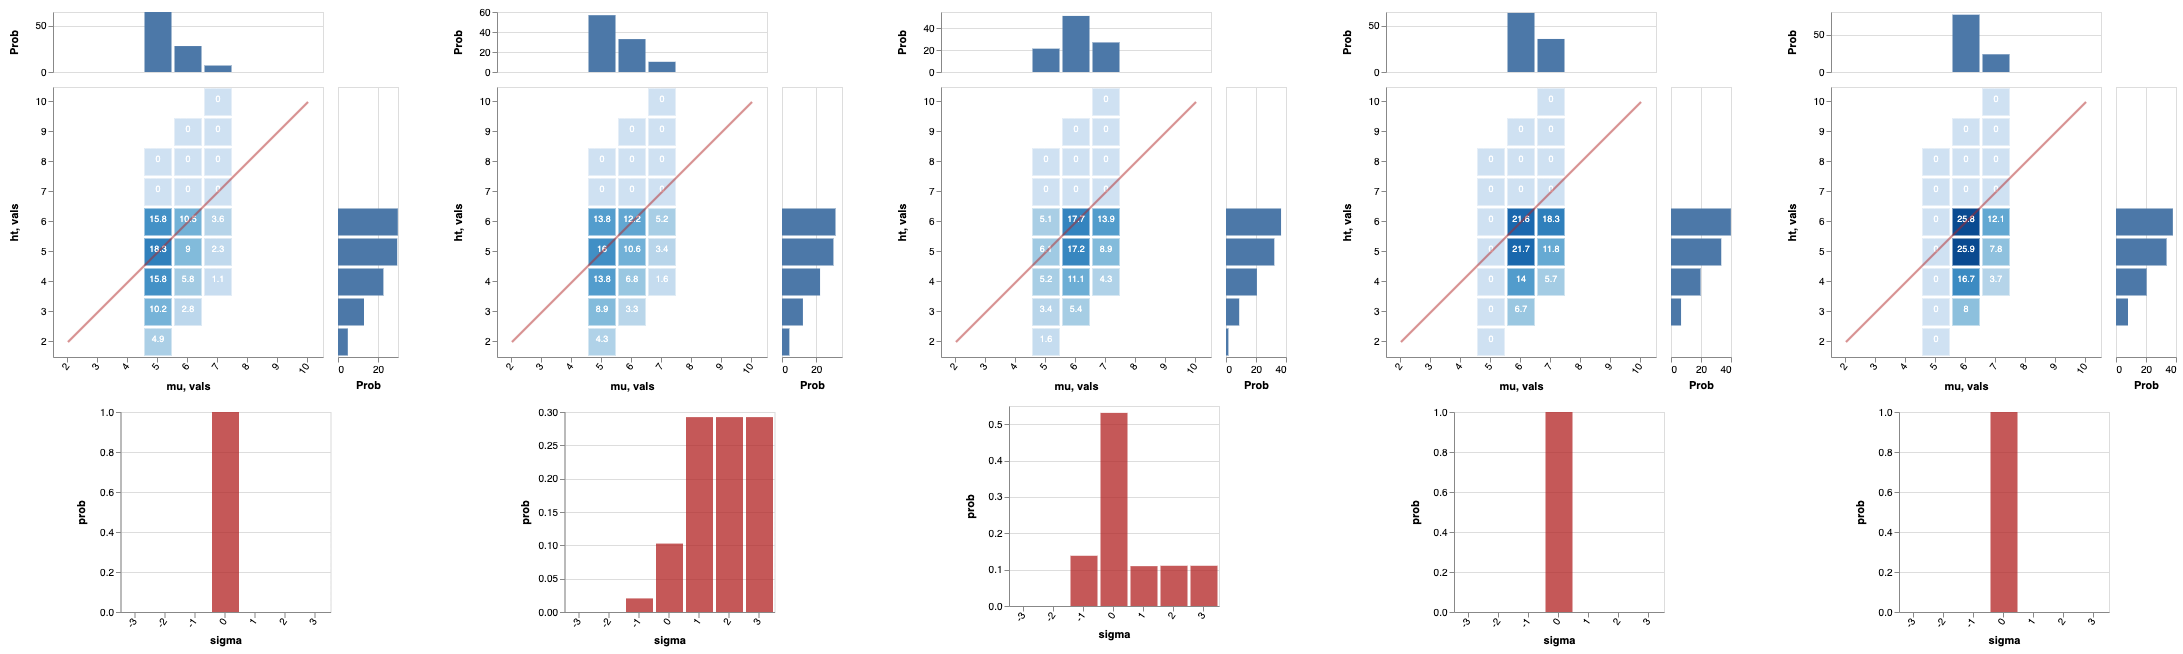

In [29]:
writeIORef cacheRef (0, Map.empty) 
  
vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUMAllExact cacheRef (0, UShrt, allDenExact0)
  , lp infoLUMAllExact >>= \l -> listener infoLUMAllExact cacheRef (0, UShrt, l)
  , listener infoLUMAllExact cacheRef (1, UShrt, allDenExact0)
  , listener infoLUMAllExact cacheRef (2, UShrt, allDenExact0)
  , listener infoLUMAllExact cacheRef (3, UShrt, allDenExact0)
  ]

### Uncertain Equative Utterances

All adjectival utterances are now interpreted as entailing that everyone's height is equal to Bill's height, but Bill's height is not known.

There is no real baseline here, since there is no privileged belief for Bill's height, but let's arbitrarily set it at $6$.

Other interpretations place Bill's height at other values, and additionally guarantee that that height is within a certain upper/lower percentile of the comparison class

\begin{align}
  [\![\text{John, Mary, and Fred are all Bill-tall}]\!]_{b,\sigma} &:= \lambda \langle w,\mu\rangle.\, b \geq \mu + \sigma \land \forall x.\,\textsf{ht}_w(x) \geq b\\
  [\![\text{John, Mary, and Fred are all Bill-short}]\!]_{b,\sigma} &:= \lambda \langle w,\mu\rangle.\, b \leq \mu + \sigma \land \forall x.\,\textsf{ht}_w(x) \leq b 
\end{align}

[eqDens in pictures](eqDens.vl)

In [35]:
allDenEq0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> all (\x -> ht w x >= 6) domain) indices
        f UShrt = filter (\(w,i) -> all (\x -> ht w x <= 6) domain) indices

eqAllDens :: [Lexicon]
eqAllDens = 
  do d <- [-sigma .. sigma] :: [Int]
     b <- [4 .. 8]
     let f UNone = indices
         f UTall = filter (\(w,i) -> all (\x -> ht w x >= b && b >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> all (\x -> ht w x <= b && b <= i + d) domain) indices
     return (Lex (d * 10 + b) f)

#### listener hears:

> "John, Mary, and Fred are all as tall as Bill"

In [36]:
infoLUMAllEq = infoBaselineAll {lp = unif eqAllDens}

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that John is very probably of normal height for someone in the comparison class (this was already guaranteed by the prior), though it remains possible that he is slightly above what's normal (the conclusions for others are identical)

The evaluativity effect is weak

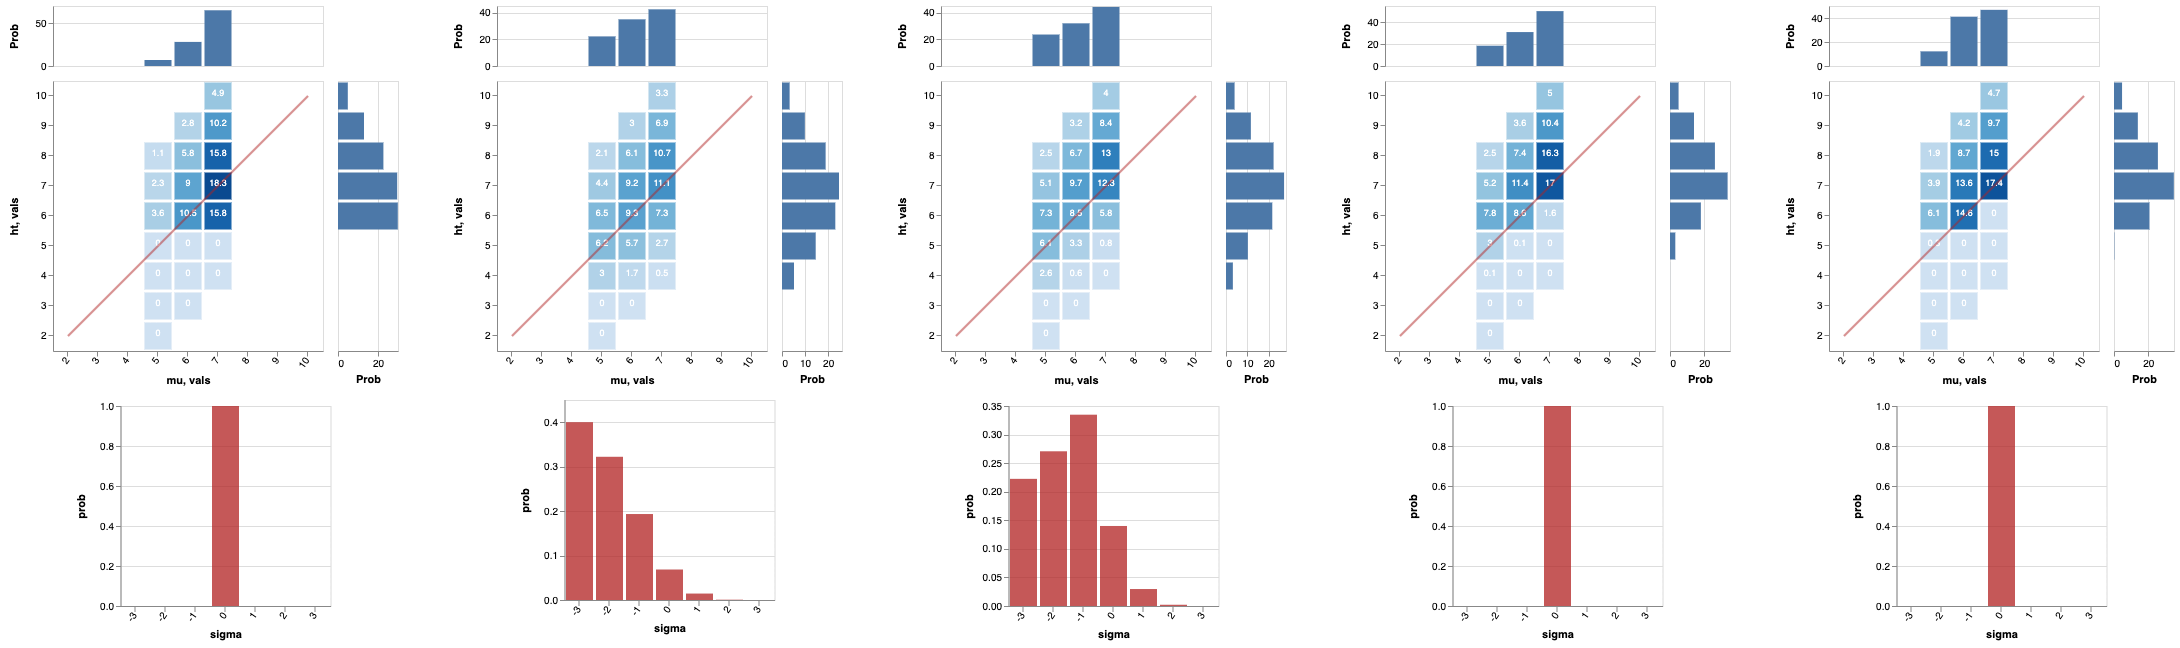

In [33]:
writeIORef cacheRef (0, Map.empty)

mkEqGraph m = do
  heat <- enumD (first (`ht` John)                    . fst <$> m)
  bar  <- enumD (floor . (/10) . fromIntegral . lexID . snd <$> m)
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (margHeatFromDist heat), fromVL (sdBarFromDist sigma bar)]
    ]

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ listener infoLUMAllEq cacheRef (0, UTall, allDenEq0)
  , lp infoLUMAllEq >>= \l -> listener infoLUMAllEq cacheRef (0, UTall, l)
  , listener infoLUMAllEq cacheRef (1, UTall, allDenEq0)
  , listener infoLUMAllEq cacheRef (2, UTall, allDenEq0)
  , listener infoLUMAllEq cacheRef (3, UTall, allDenEq0)
  ]

#### listener hears:

> "John, Mary, and Fred are all as short as Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights.

But now, the various strengthenings lead ultimately to a pragmatic conclusion that John is almost certainly below the median (same for others)

As expected, the evaluative effect is much stronger

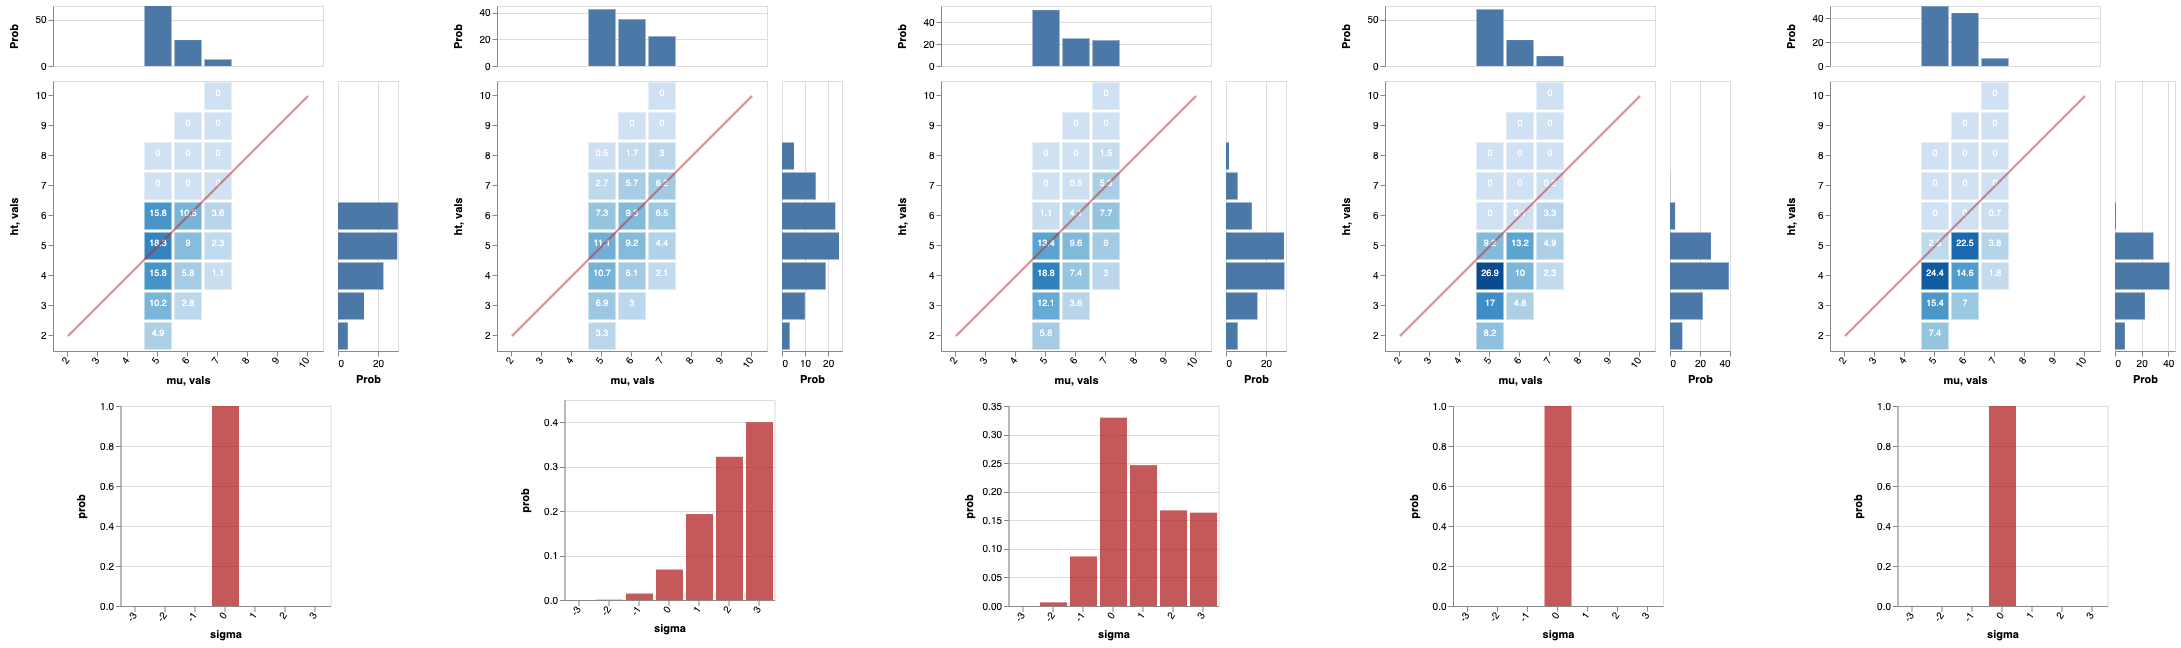

In [34]:
writeIORef cacheRef (0, Map.empty)  
  
vlShow . sidewaysDists <$> traverse mkEqGraph
  [ listener infoLUMAllEq cacheRef (0, UShrt, allDenEq0)
  , lp infoLUMAllEq >>= \l -> listener infoLUMAllEq cacheRef (0, UShrt, l)
  , listener infoLUMAllEq cacheRef (1, UShrt, allDenEq0)
  , listener infoLUMAllEq cacheRef (2, UShrt, allDenEq0)
  , listener infoLUMAllEq cacheRef (3, UShrt, allDenEq0)
  ]

## Some

### Positive Utterances

Keeping all priors about indices and utterances the same, we now model pragmatic listeners who consider various strengthenings of the assertion (note that these are strengthenings in the *dynamic sense*; the pure informational content about John's and Mary's heights is the same in all lexica)

Baseline `anyDen0` of both antonyms is that they are tautologies (everyone is within 3 steps of the median)

On other interpretations, 'Tall' (resp. 'Short') place **some** of John, Mary, and Fred in a certain upper (resp. lower) percentile of the comparison class

\begin{align}
  [\![\text{Either John, Mary, or Fred is tall}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \exists x.\,\textsf{ht}_w(x) \geq \mu + \sigma\\
  [\![\text{Either John, Mary, or Fred is short}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \exists x.\,\textsf{ht}_w(x) \leq \mu + \sigma
\end{align}

In [37]:
anyDen0 :: Lexicon
anyDen0 = Lex 0 f
  where f _ = indices

posAnyDens :: [Lexicon]
posAnyDens =
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> any (\x -> ht w x >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> any (\x -> ht w x <= i + d) domain) indices
     return (Lex d f)

In [38]:
infoBaselineAny = Priors indicesPriorFlat utterancePrior1 (unif [anyDen0])
infoLUMAny = infoBaselineAny {lp = unif posAnyDens}

#### listener hears:

> "Either John, Mary, or Fred is tall"

Here it makes less sense to inspect the listener's posteriors about a particular individual, like John, 's height, since none of the utterances on any of their interpretations entail anything about John, *per se*

So instead we plot the joint distribution of the median height and the **maximum** height of any entity

Agents now become extremely confident that the maximal height exceeds the class standard, though they remain in the dark about what that standard is

And as seen in the `ht` marginal, even though the standard remains unknown, the belief that someone's height exceeds it leads to a (positively skewed) evaluative distribution over maximal heights

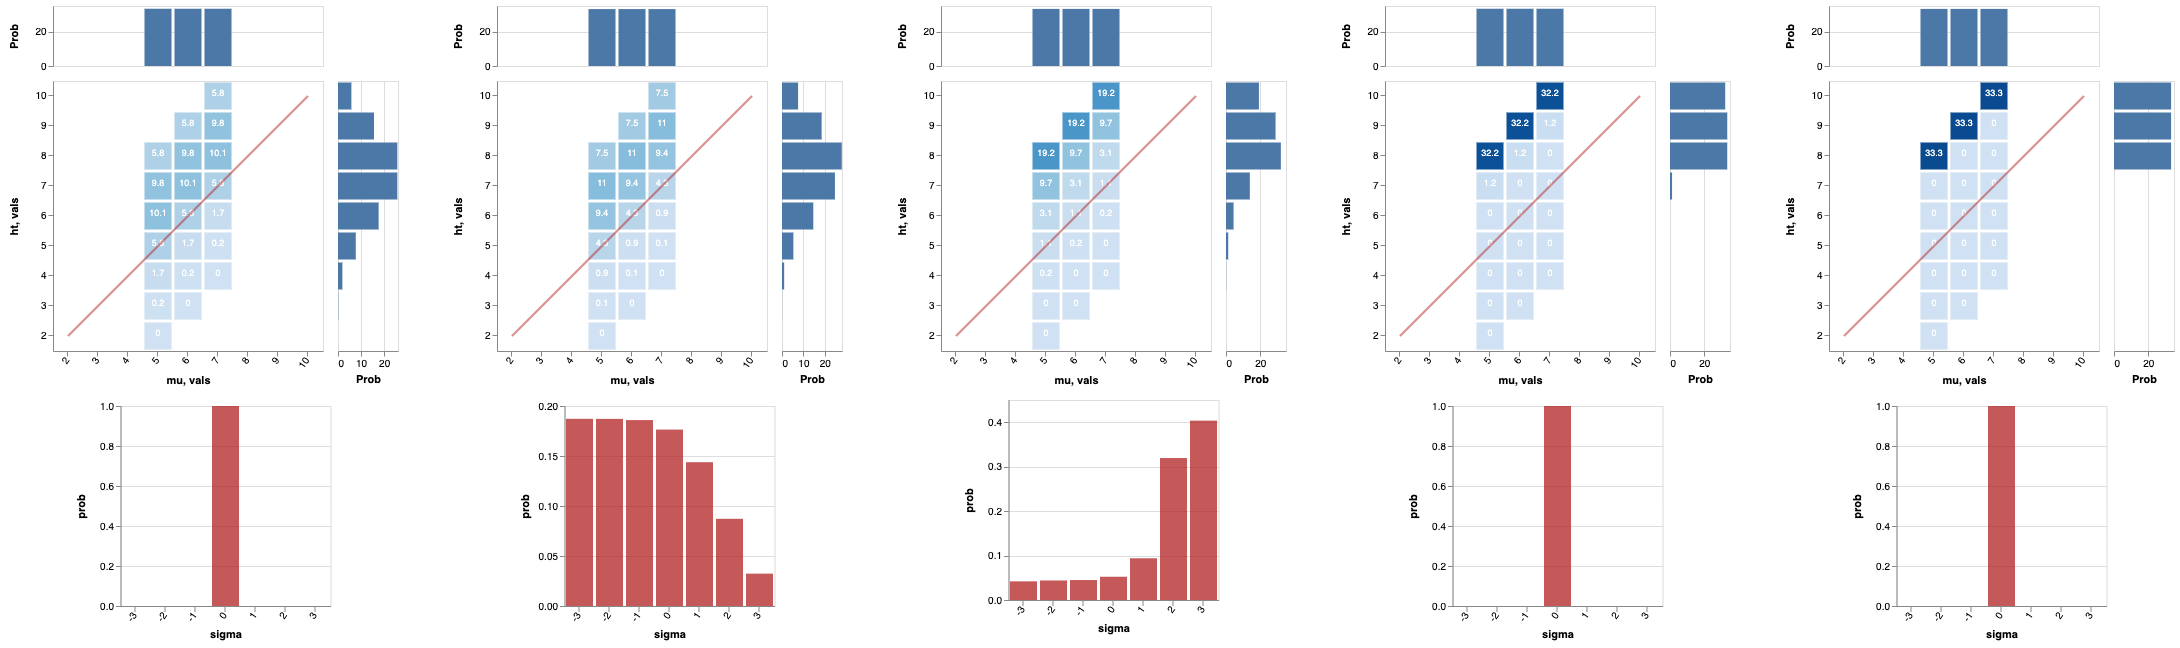

In [39]:
writeIORef cacheRef (0, Map.empty)

mkMaxGraph m = do
  heat <- enumD (first (\w -> maximum $ fmap (ht w) domain) . fst <$> m)
  bar  <- enumD (lexID                                      . snd <$> m)
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (margHeatFromDist heat), fromVL (sdBarFromDist sigma bar)]
    ]
  
vlShow . sidewaysDists <$> traverse mkMaxGraph
  [ listener infoLUMAny cacheRef (0, UTall, anyDen0)
  , lp infoLUMAny >>= \l -> listener infoLUMAny cacheRef (0, UTall, l)
  , listener infoLUMAny cacheRef (1, UTall, anyDen0)
  , listener infoLUMAny cacheRef (2, UTall, anyDen0)
  , listener infoLUMAny cacheRef (3, UTall, anyDen0)
  ]

#### listener hears:

> "Either John, Mary, or Fred is short"

Again we plot the joint distribution of the median height and the **minimum** height of any entity

Agents become even more extremely confident that the minimal height falls below the class standard, though they remain in the dark about what that standard is

And as seen in the `ht` marginal, even though the standard remains unknown, the belief that someone's height is below it leads to a (negatively skewed) evaluative distribution over minimal heights

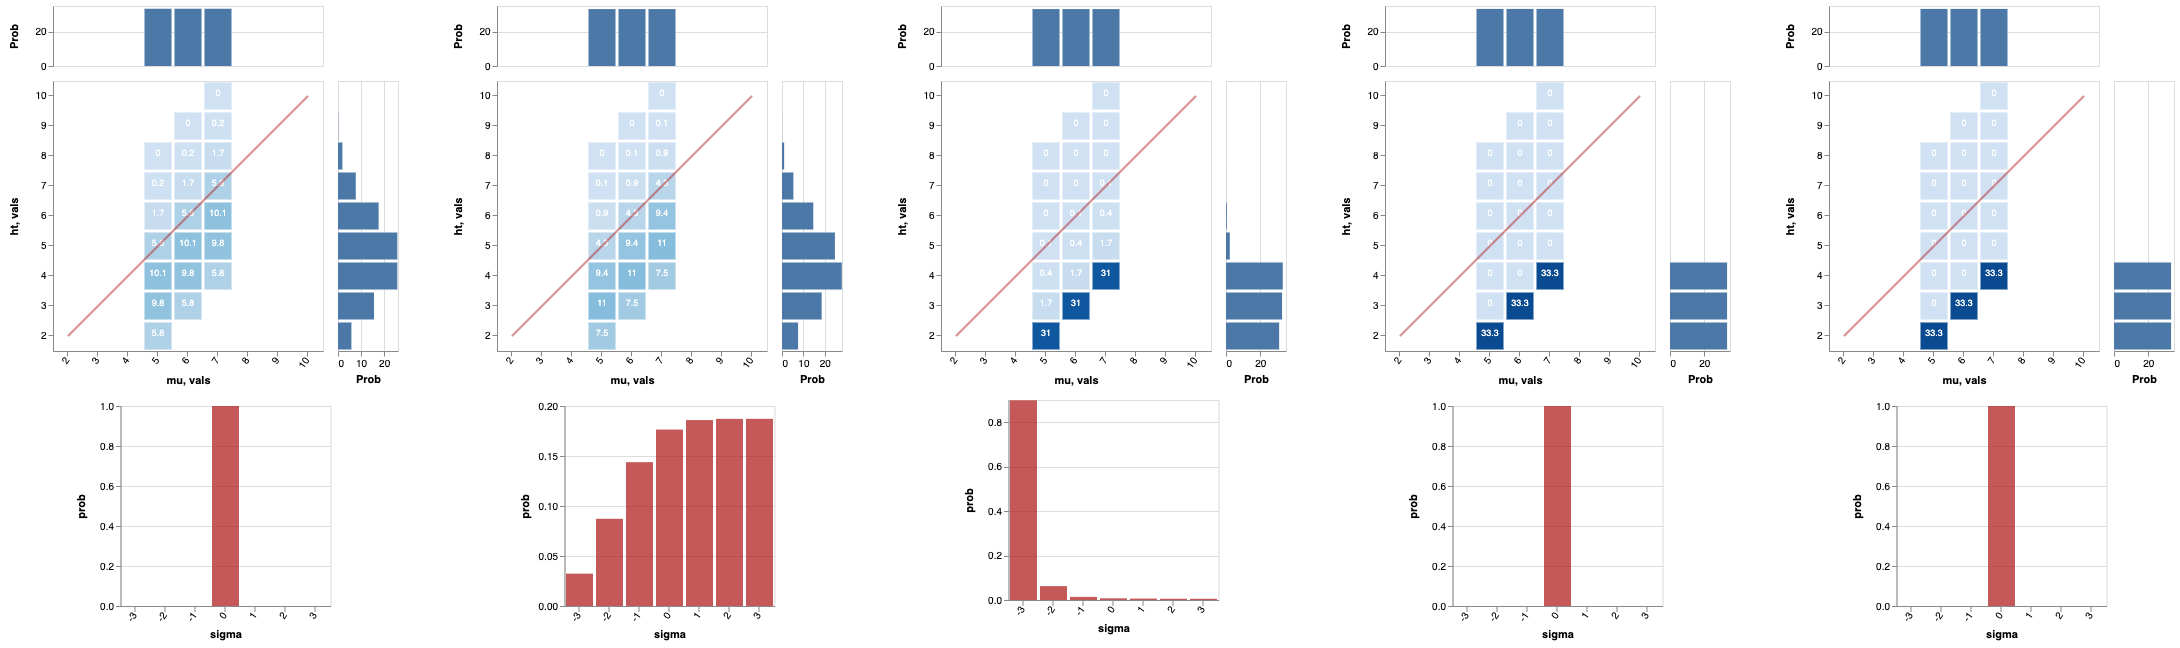

In [60]:
writeIORef cacheRef (0, Map.empty)

mkMinGraph m = do
  heat <- enumD (first (\w -> minimum $ fmap (ht w) domain) . fst <$> m)
  bar  <- enumD (lexID                                      . snd <$> m)
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (margHeatFromDist heat), fromVL (sdBarFromDist sigma bar)]
    ]

vlShow . sidewaysDists <$> traverse mkMinGraph
  [ listener infoLUMAny cacheRef (0, UShrt, anyDen0)
  , lp infoLUMAny >>= \l -> listener infoLUMAny cacheRef (0, UShrt, l)
  , listener infoLUMAny cacheRef (1, UShrt, anyDen0)
  , listener infoLUMAny cacheRef (2, UShrt, anyDen0)
  , listener infoLUMAny cacheRef (3, UShrt, anyDen0)
  ]

### Degree demonstrative Utterances

All adjectival utterances are now interpreted as entailing that someone's height is 6

In the baseline lexicon `anyDenExact0`, this is all that is contributed by an utterance

Other interpretations place someone's height at 6 and additionally guarantee that 6 is within a certain upper/lower percentile of the comparison class

\begin{align}
  [\![\text{Either John, Mary, or Fred is 6-tall}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, 6 \geq \mu + \sigma \land \exists x.\,\textsf{ht}_w(x) \geq 6\\
  [\![\text{Either John, Mary, or Fred is 6-short}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, 6 \leq \mu + \sigma \land \exists x.\,\textsf{ht}_w(x) \leq 6
\end{align}

In [40]:
anyDenExact0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> any (\x -> ht w x >= 6) domain) indices
        f UShrt = filter (\(w,i) -> any (\x -> ht w x <= 6) domain) indices

exactAnyDens :: [Lexicon]
exactAnyDens = 
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> any (\x -> ht w x >= 6 && 6 >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> any (\x -> ht w x <= 6 && 6 <= i + d) domain) indices
     return (Lex d f)

#### listener hears:

> "Bill's height is 6; either John, Mary, or Fred is that tall too"

In [41]:
infoLUMAnyExact = infoBaselineAny {lp = unif exactAnyDens}

We plot the distribution over maximum heights

The various conceivable strengthenings lead ultimately to a pragmatic conclusion that 6 is very likely above the standard

So there is a (surprisingly) strong evaluative effect here!

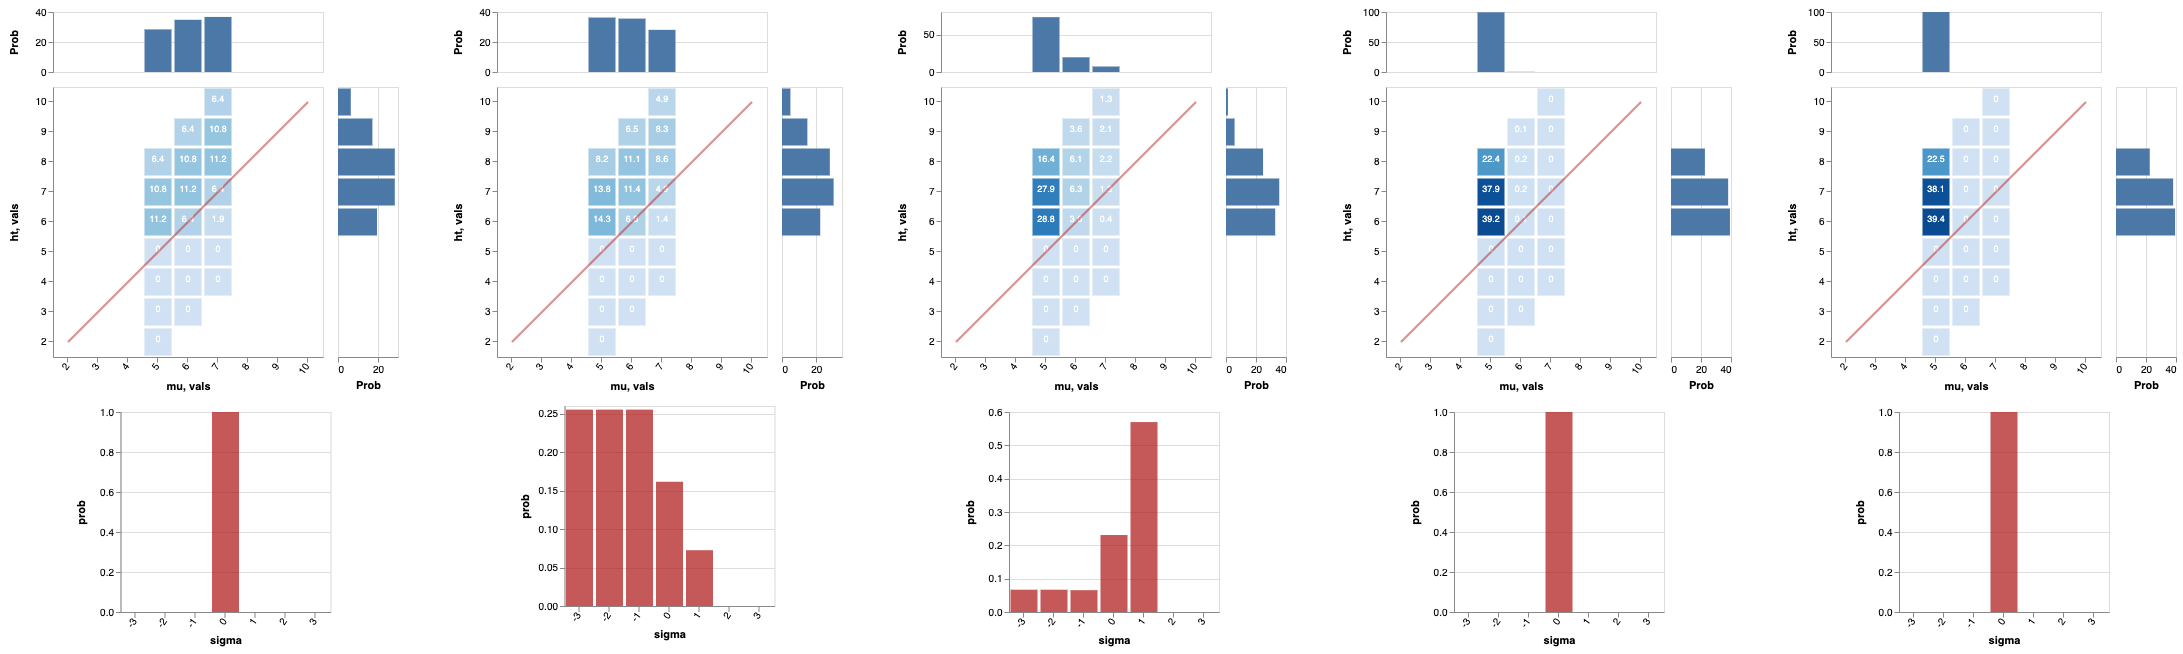

In [42]:
writeIORef cacheRef (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkMaxGraph
  [ listener infoLUMAnyExact cacheRef (0, UTall, anyDenExact0)
  , lp infoLUMAnyExact >>= \l -> listener infoLUMAnyExact cacheRef (0, UTall, l)
  , listener infoLUMAnyExact cacheRef (1, UTall, anyDenExact0)
  , listener infoLUMAnyExact cacheRef (2, UTall, anyDenExact0)
  , listener infoLUMAnyExact cacheRef (3, UTall, anyDenExact0)
  ]

#### listener hears:

> "Bill's height is 6; Either John, Mary, or Fred is that short too"

And again, we plot the distribution over minimum heights

But now, the various strengthenings lead ultimately to a pragmatic conclusion that 6 is almost certainly below the median

The evaluativity effect here is much stronger

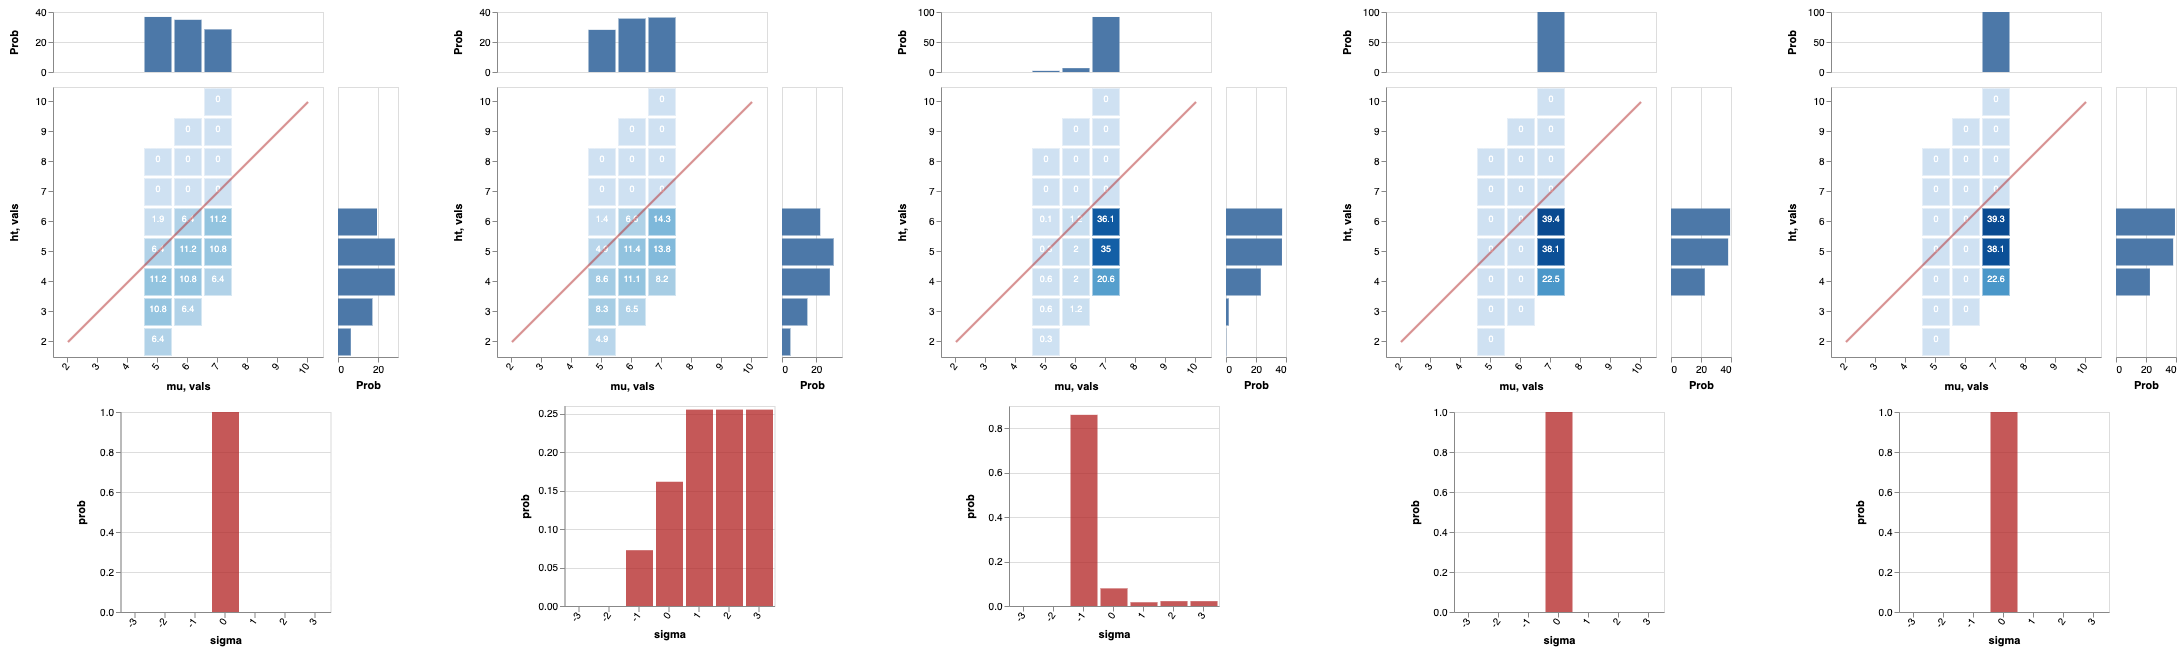

In [61]:
writeIORef cacheRef (0, Map.empty) 

vlShow . sidewaysDists <$> traverse mkMinGraph
  [ listener infoLUMAnyExact cacheRef (0, UShrt, anyDenExact0)
  , lp infoLUMAnyExact >>= \l -> listener infoLUMAnyExact cacheRef (0, UShrt, l)
  , listener infoLUMAnyExact cacheRef (1, UShrt, anyDenExact0)
  , listener infoLUMAnyExact cacheRef (2, UShrt, anyDenExact0)
  , listener infoLUMAnyExact cacheRef (3, UShrt, anyDenExact0)
  ]

## Uncertain Equative

All adjectival utterances are now interpreted as entailing that John's and Mary's heights are equal to Bill's height, but Bill's height is not known.

There is no real baseline here, since there is no privileged belief for Bill's height, but let's arbitrarily set it at $6$.

Other interpretations place John's and Mary's heights at other values, and additionally guarantee that those heights are within a certain upper/lower percentile of the comparison class

\begin{align}
  [\![\text{John or Mary is Bill-tall}]\!]_{b,\sigma} &:= \lambda \langle w,\mu\rangle.\, b \geq \mu + \sigma \land \exists x.\,\textsf{ht}_w(x) \geq b\\ 
  [\![\text{John or Mary is Bill-short}]\!]_{b,\sigma} &:= \lambda \langle w,\mu\rangle.\, b \leq \mu + \sigma \land \exists x.\,\textsf{ht}_w(x) \leq b\\ 
\end{align}

[eqDens in pictures](eqDens.vl)

In [51]:
anyDenEq0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> any (\x -> ht w x >= 6) domain) indices
        f UShrt = filter (\(w,i) -> any (\x -> ht w x <= 6) domain) indices

eqAnyDens :: [Lexicon]
eqAnyDens = 
  do d <- [-sigma .. sigma] :: [Int]
     b <- [4 .. 8]
     let f UNone = indices
         f UTall = filter (\(w,i) -> any (\x -> ht w x >= b && b >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> any (\x -> ht w x <= b && b <= i + d) domain) indices
     return (Lex (d * 10 + b) f)

### Pragmatic agents

#### Pragmatic listener hears

> "John or Mary is as tall as Bill"

Cutting to the chase, consider a listener that is not settled on one of these stengthenings.

In [52]:
infoLUMAnyEq = infoBaselineAny {lp = unif eqAnyDens}

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that John is probably of normal height for someone in the comparison class (this was already guaranteed by the prior), though it's possible that he is relatively tall compared to the median (the conclusions for Mary are identical)

Again, we might say if there's any evaluativity here at all, it is very weak

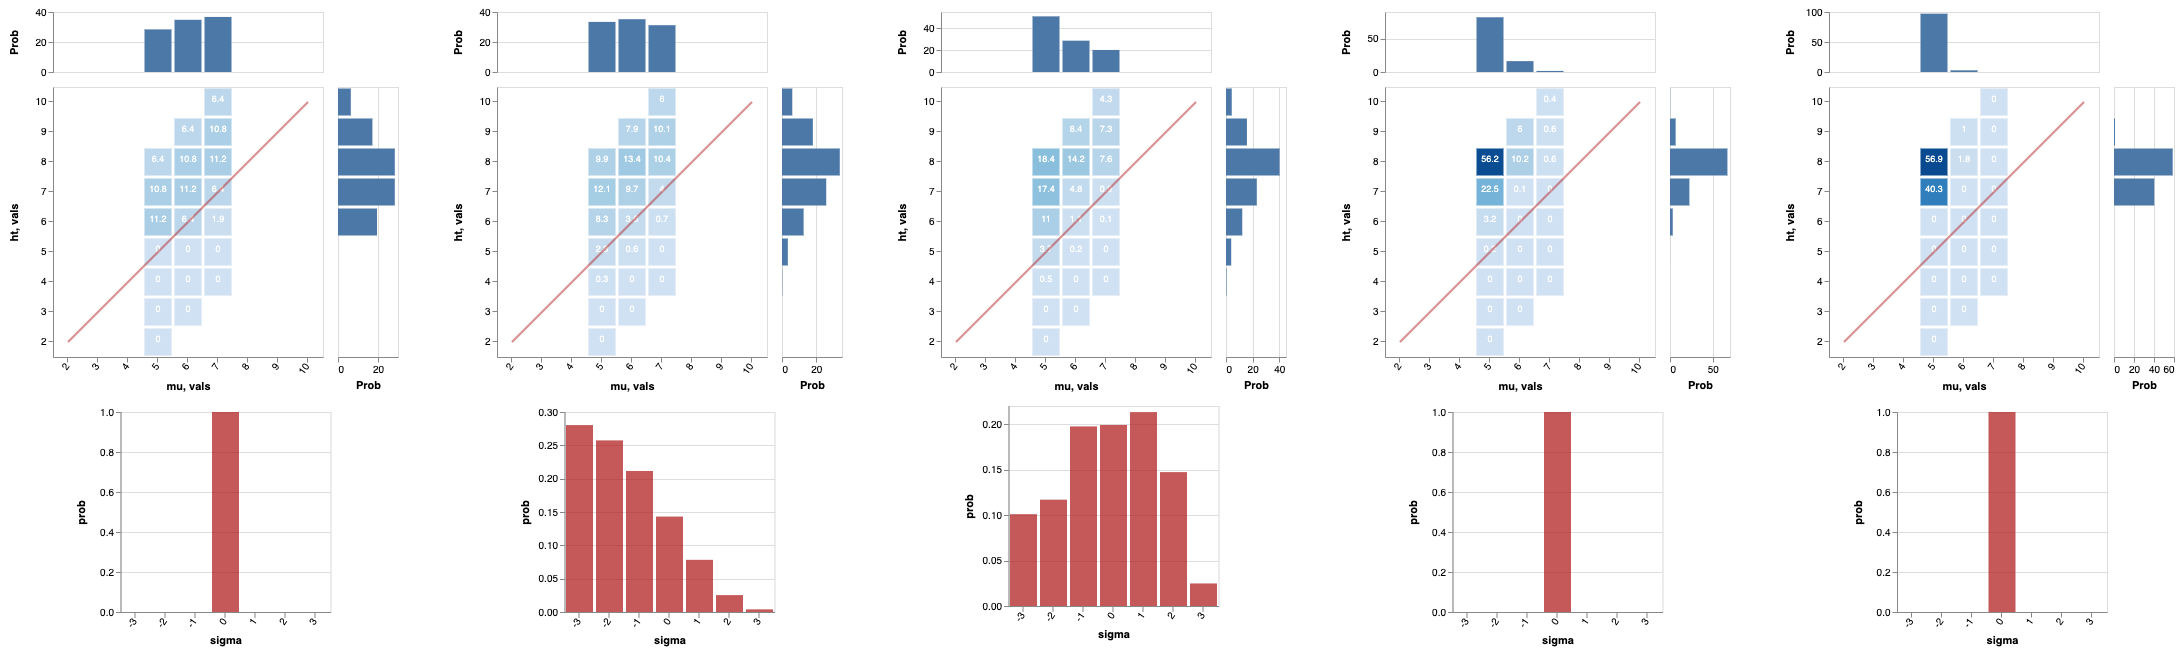

In [53]:
writeIORef cacheRef (0, Map.empty)

mkEqMaxGraph m = do
  heat <- enumD (first (\w -> maximum $ fmap (ht w) domain) . fst <$> m)
  bar  <- enumD (floor . (/10) . fromIntegral . lexID       . snd <$> m)
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (margHeatFromDist heat), fromVL (sdBarFromDist sigma bar)]
    ]

vlShow . sidewaysDists <$> traverse mkEqMaxGraph
  [ listener infoLUMAnyEq cacheRef (0, UTall, anyDenEq0)
  , lp infoLUMAnyEq >>= \l -> listener infoLUMAnyEq cacheRef (0, UTall, l)
  , listener infoLUMAnyEq cacheRef (1, UTall, anyDenEq0)
  , listener infoLUMAnyEq cacheRef (2, UTall, anyDenEq0)
  , listener infoLUMAnyEq cacheRef (3, UTall, anyDenEq0)
  ]

#### Pragmatic listener hears:

> "John or Mary is as short as Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights.

But now, the various strengthenings lead ultimately to a pragmatic conclusion that John is almost certainly below the median (same for Mary)

As expected, the evaluative effect is much stronger

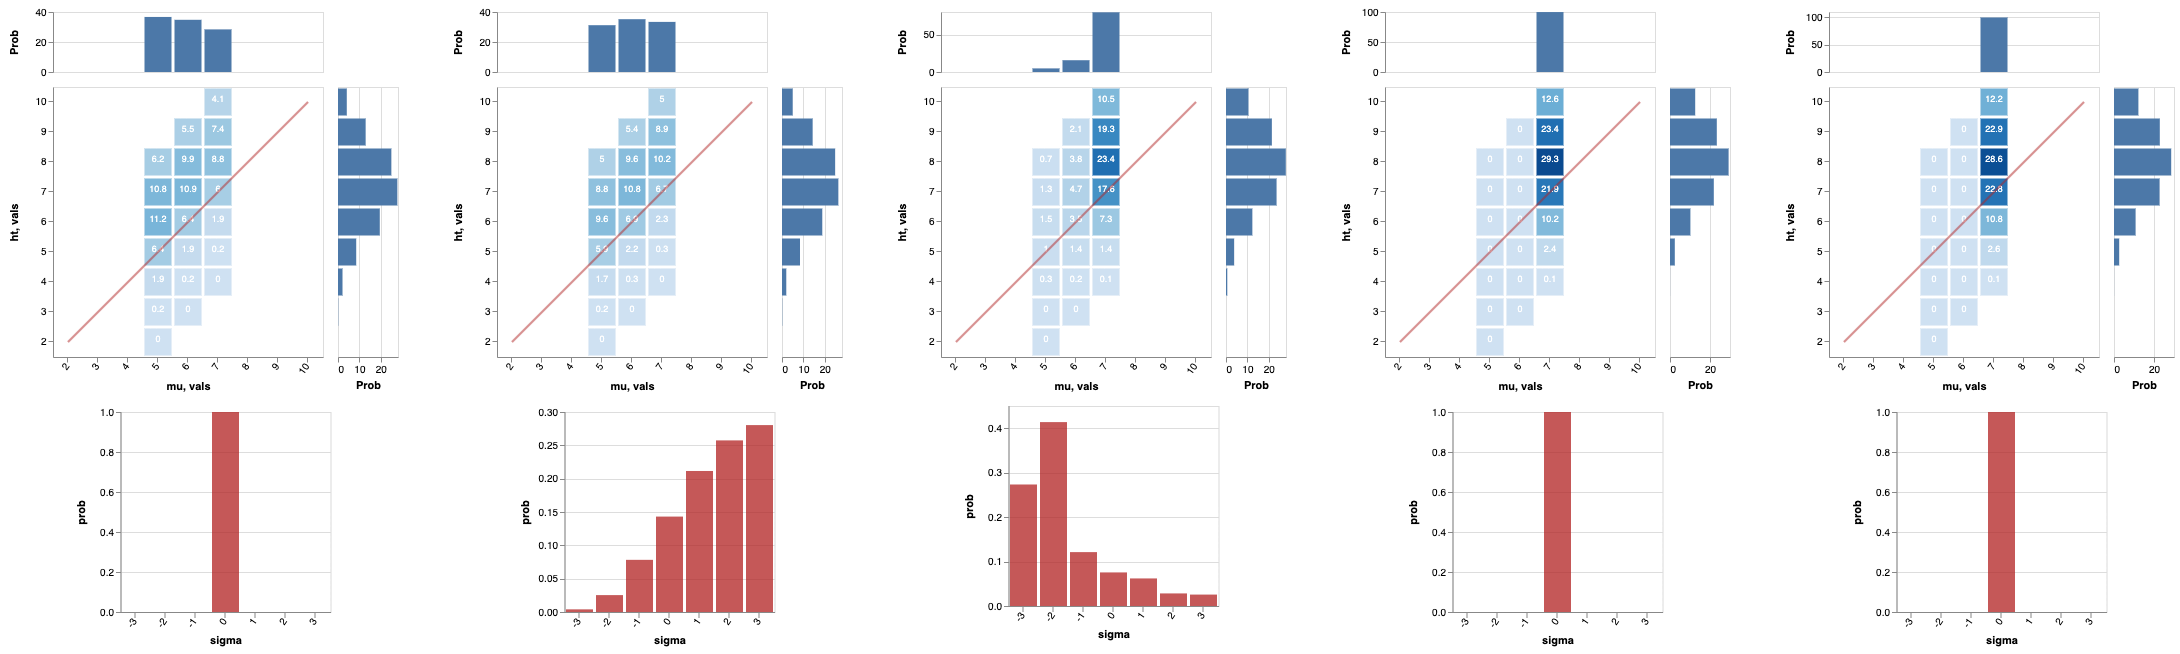

In [54]:
writeIORef cacheRef (0, Map.empty)  

vlShow . sidewaysDists <$> traverse mkEqMaxGraph
  [ listener infoLUMAnyEq cacheRef (0, UShrt, anyDenEq0)
  , lp infoLUMAnyEq >>= \l -> listener infoLUMAnyEq cacheRef (0, UShrt, l)
  , listener infoLUMAnyEq cacheRef (1, UShrt, anyDenEq0)
  , listener infoLUMAnyEq cacheRef (2, UShrt, anyDenEq0)
  , listener infoLUMAnyEq cacheRef (3, UShrt, anyDenEq0)
  ]

# None

In [44]:
none p xs = not $ any p xs

## Positive Utterances

Keeping all priors about indices and utterances the same, we now model pragmatic listeners who consider various strengthenings of the assertion (note that these are strengthenings in the *dynamic sense*; the pure informational content about John's and Mary's heights is the same in all lexica)

Baseline `nonDen0` of both antonyms is that they are contradictions (John, Mary, and Fred are not within 2 steps of the median)

On other interpretations, 'Tall' (resp. 'Short') places **none** of John, Mary, and Fred in a certain upper (resp. lower) percentile of the comparison class

\begin{align}
[\![\text{None of John, Mary, or Fred is tall}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \neg\exists x.\,\textsf{ht}_w(x) \geq \mu + \sigma\\
[\![\text{None of John, Mary, or Fred is short}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \neg\exists x.\,\textsf{ht}_w(x) \leq \mu + \sigma
\end{align}

In [45]:
nonDen0 :: Lexicon
nonDen0 = Lex 0 f
  where f _ = indices

posNonDens :: [Lexicon]
posNonDens =
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> none (\x -> ht w x >= i + d) domain) indices
         f UShrt = filter (\(w,i) -> none (\x -> ht w x <= i + d) domain) indices
     return (Lex d f)

In [46]:
infoBaselineNon = Priors indicesPriorFlat utterancePrior1 (unif [nonDen0])
infoLUMNon = infoBaselineNon {lp = unif posNonDens}

### Pragmatic agents

#### Pragmatic listener hears:

> "Neither John, Mary, nor Fred is tall"

These agents become very confident that John's height exceeds the class standard, though they remain in the dark about what that standard is (the conclusions for Mary/Fred are identical)

And as seen in the `htest` marginal, even though the standard remains unknown, the belief that John's height exceeds it leads to a (positively skewed) evaluative distribution over worlds

The resulting evaluative inference is detectable, but not extreme; curiously, the later agents become convinced that John is either normal or much taller than normal, whatever normal is

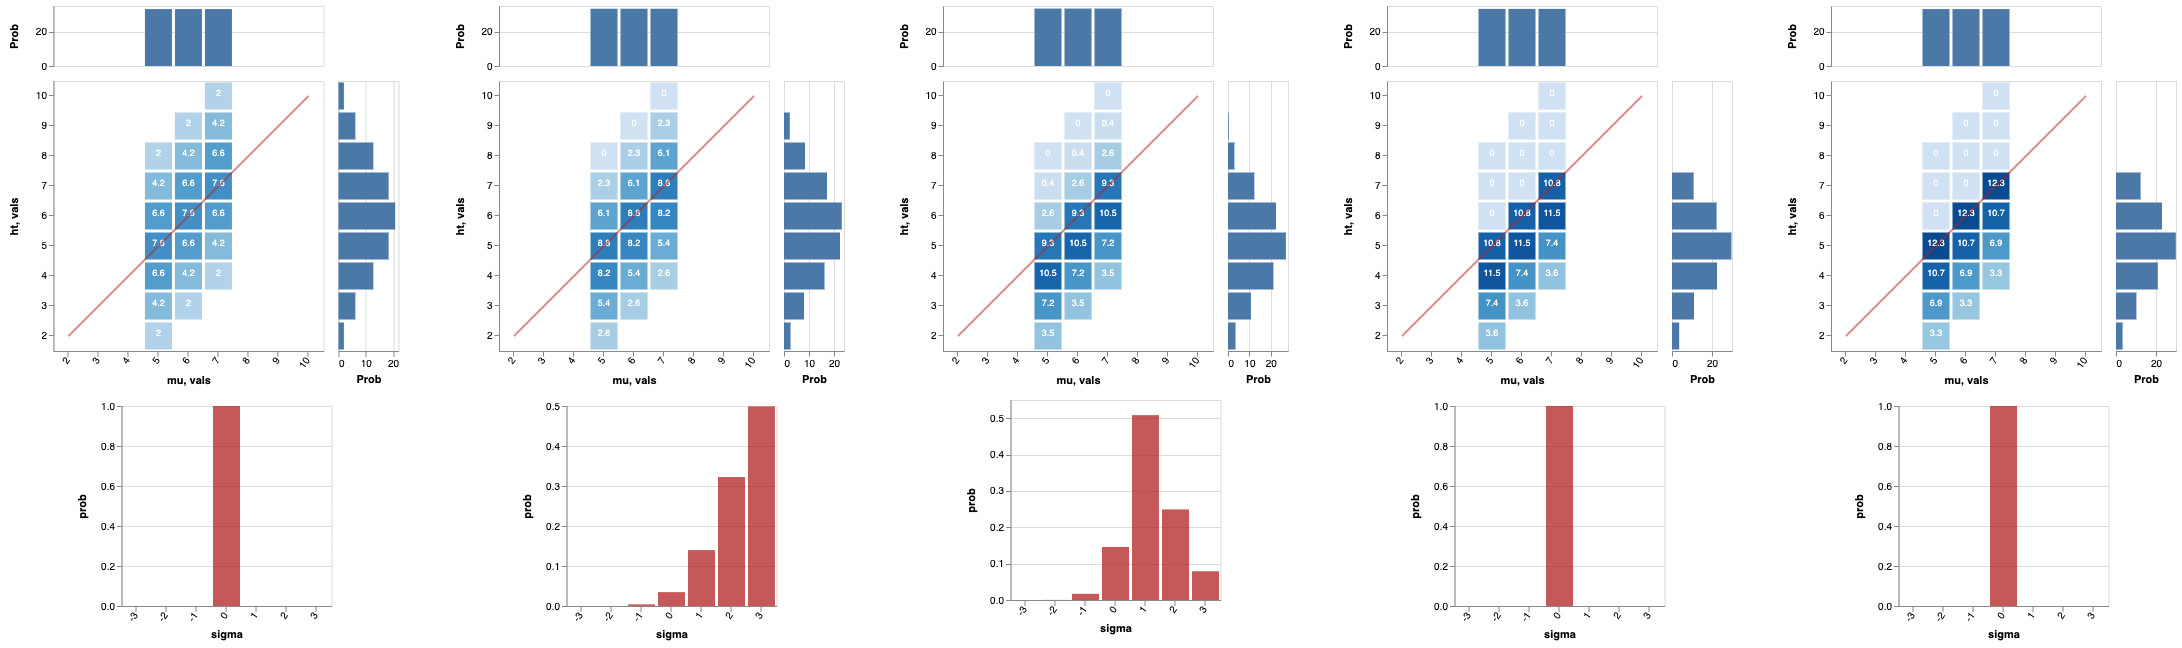

In [64]:
writeIORef cacheRef (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUMNon cacheRef (0, UTall, nonDen0)
  , lp infoLUMNon >>= \l -> listener infoLUMNon cacheRef (0, UTall, l)
  , listener infoLUMNon cacheRef (1, UTall, nonDen0)
  , listener infoLUMNon cacheRef (2, UTall, nonDen0)
  , listener infoLUMNon cacheRef (3, UTall, nonDen0)
  ]

#### Pragmatic listener hears:

> "Neither John, Mary, nor Fred is short"

These agents become quite certain that John's height falls below the class standard, though they remain in the dark about what that standard is (the conclusions for Mary are identical)

And as seen in the `ht` marginal, even though the standard remains unknown, the belief that John's height falls below it it leads to a (negatively skewed) evaluative distribution over worlds

The evaluativity effect is almost perfectly symmetrical to the positive case; again, the later agents become convinced that John is either normal or much shorter than normal, whatever normal is

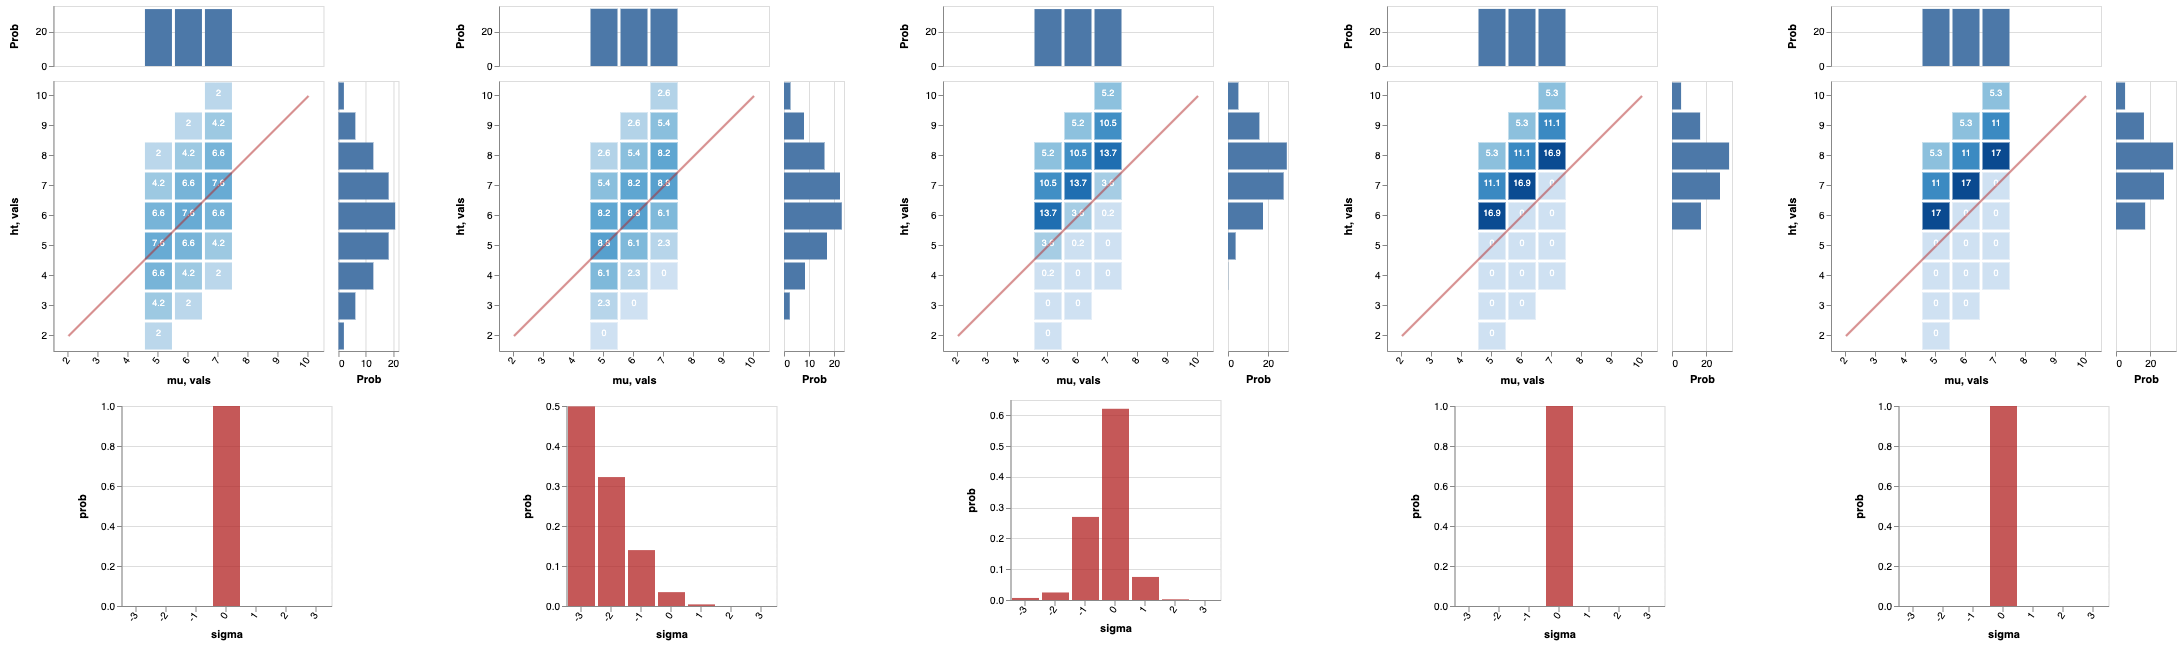

In [65]:
writeIORef cacheRef (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUMNon cacheRef (0, UShrt, nonDen0)
  , lp infoLUMNon >>= \l -> listener infoLUMNon cacheRef (0, UShrt, l)
  , listener infoLUMNon cacheRef (1, UShrt, nonDen0)
  , listener infoLUMNon cacheRef (2, UShrt, nonDen0)
  , listener infoLUMNon cacheRef (3, UShrt, nonDen0)
  ]

## Degree demonstrative

All adjectival utterances are now interpreted as entailing that nobody's height is 6

In the baseline lexicon `nonDenExact0`, this is all that is contributed by an utterance

Other interpretations place their heights at 6 and additionally guarantee that those heights are within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{Neither John, Mary, nor Fred is 6-tall}]\!]_{\sigma} := \lambda \langle w,\mu\rangle.\, 6 \geq \mu + \sigma \land \neg\exists x.\,\textsf{ht}_w(x) = 6 \end{equation}

In [47]:
nonDenExact0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> none (\x -> ht w x >= 6) domain) indices
        f UShrt = filter (\(w,i) -> none (\x -> ht w x <= 6) domain) indices

exactNonDens :: [Lexicon]
exactNonDens = 
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> 6 >= i + d && none (\x -> ht w x >= 6) domain) indices
         f UShrt = filter (\(w,i) -> 6 <= i + d && none (\x -> ht w x <= 6) domain) indices
     return (Lex d f)

### Pragmatic agents

#### Pragmatic listener hears

> "Bill's height is 6; either John, Mary, or Fred is that tall too"

Cutting to the chase, consider a listener that is not settled on one of these stengthenings

In [48]:
infoLUMNonExact = infoBaselineNon {lp = unif exactNonDens}

Unlike the `all` utterances, the lexica no longer entail that John's height is 6, so there remains a non-degenerate distribution over worlds

The various conceivable strengthenings lead ultimately to a pragmatic conclusion that 6 is probably normal for the height of someone in the comparison class (this was already guaranteed by the prior), but it's possible that 6 is relatively high compared to the median

In other words, if there is any evaluativity effect, it is very weak

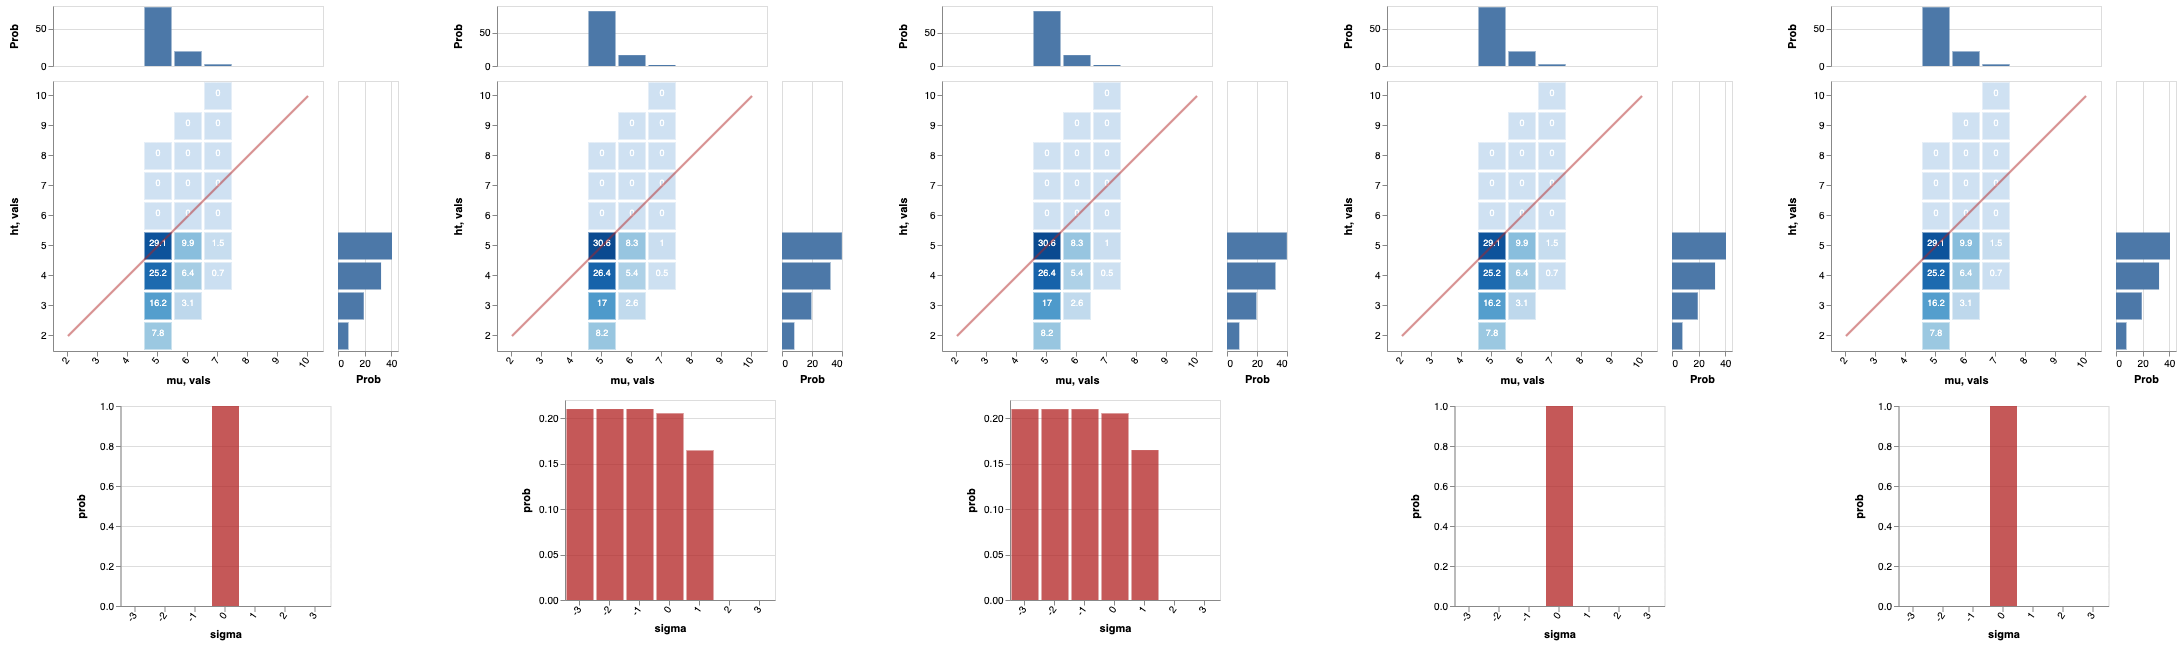

In [49]:
writeIORef cacheRef (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUMNonExact cacheRef (0, UTall, nonDenExact0)
  , lp infoLUMNonExact >>= \l -> listener infoLUMNonExact cacheRef (0, UTall, l)
  , listener infoLUMNonExact cacheRef (1, UTall, nonDenExact0)
  , listener infoLUMNonExact cacheRef (2, UTall, nonDenExact0)
  , listener infoLUMNonExact cacheRef (3, UTall, nonDenExact0)
  ]

#### Pragmatic listener hears:

> "Bill's height is 6; Either John, Mary, or Fred is that short too"

Again, since the lexica all entail that a "6-short person" has height 6, the distribution over worlds is certain

But now, the various strengthenings lead ultimately to a pragmatic conclusion that 6 is almost certainly below the median

The evaluativity effect here is much stronger

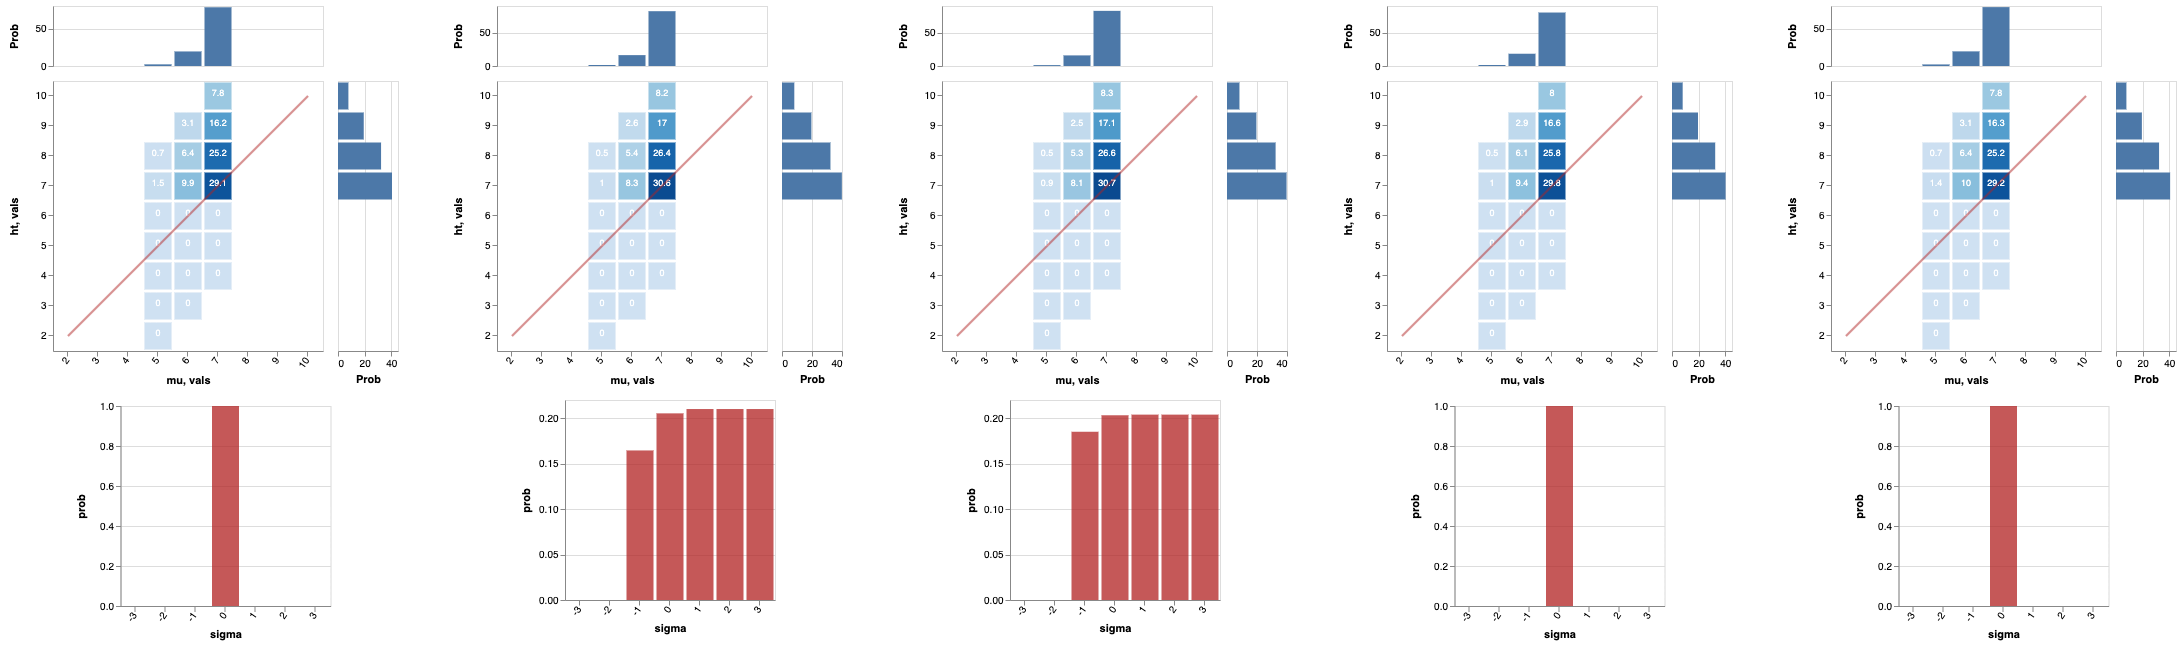

In [50]:
writeIORef cacheRef (0, Map.empty) 

vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUMNonExact cacheRef (0, UShrt, nonDenExact0)
  , lp infoLUMNonExact >>= \l -> listener infoLUMNonExact cacheRef (0, UShrt, l)
  , listener infoLUMNonExact cacheRef (1, UShrt, nonDenExact0)
  , listener infoLUMNonExact cacheRef (2, UShrt, nonDenExact0)
  , listener infoLUMNonExact cacheRef (3, UShrt, nonDenExact0)
  ]

## Uncertain Equative

All adjectival utterances are now interpreted as entailing that John's and Mary's heights are equal to Bill's height, but Bill's height is not known.

There is no real baseline here, since there is no privileged belief for Bill's height, but let's arbitrarily set it at $6$.

Other interpretations place John's and Mary's heights at other values, and additionally guarantee that those heights are within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{John or Mary is Bill-tall}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \exists x.\,\textsf{ht}_w(x) = b \land b \geq \mu + \sigma\end{equation}

[eqDens in pictures](eqDens.vl)

In [55]:
nonDenEq0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> none (\x -> ht w x >= 6) domain) indices
        f UShrt = filter (\(w,i) -> none (\x -> ht w x <= 6) domain) indices

eqNonDens :: [Lexicon]
eqNonDens = 
  do d <- [-sigma .. sigma] :: [Int]
     b <- [4 .. 8]
     let f UNone = indices
         f UTall = filter (\(w,i) -> b >= i + d && none (\x -> ht w x >= b) domain) indices
         f UShrt = filter (\(w,i) -> b <= i + d && none (\x -> ht w x <= b) domain) indices
     return (Lex (d * 10 + b) f)

### Pragmatic agents

#### Pragmatic listener hears

> "John or Mary is as tall as Bill"

Cutting to the chase, consider a listener that is not settled on one of these stengthenings.

In [56]:
infoLUMNonEq = infoBaselineNon {lp = unif eqNonDens}

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that John is probably of normal height for someone in the comparison class (this was already guaranteed by the prior), though it's possible that he is relatively tall compared to the median (the conclusions for Mary are identical)

Again, we might say if there's any evaluativity here at all, it is very weak

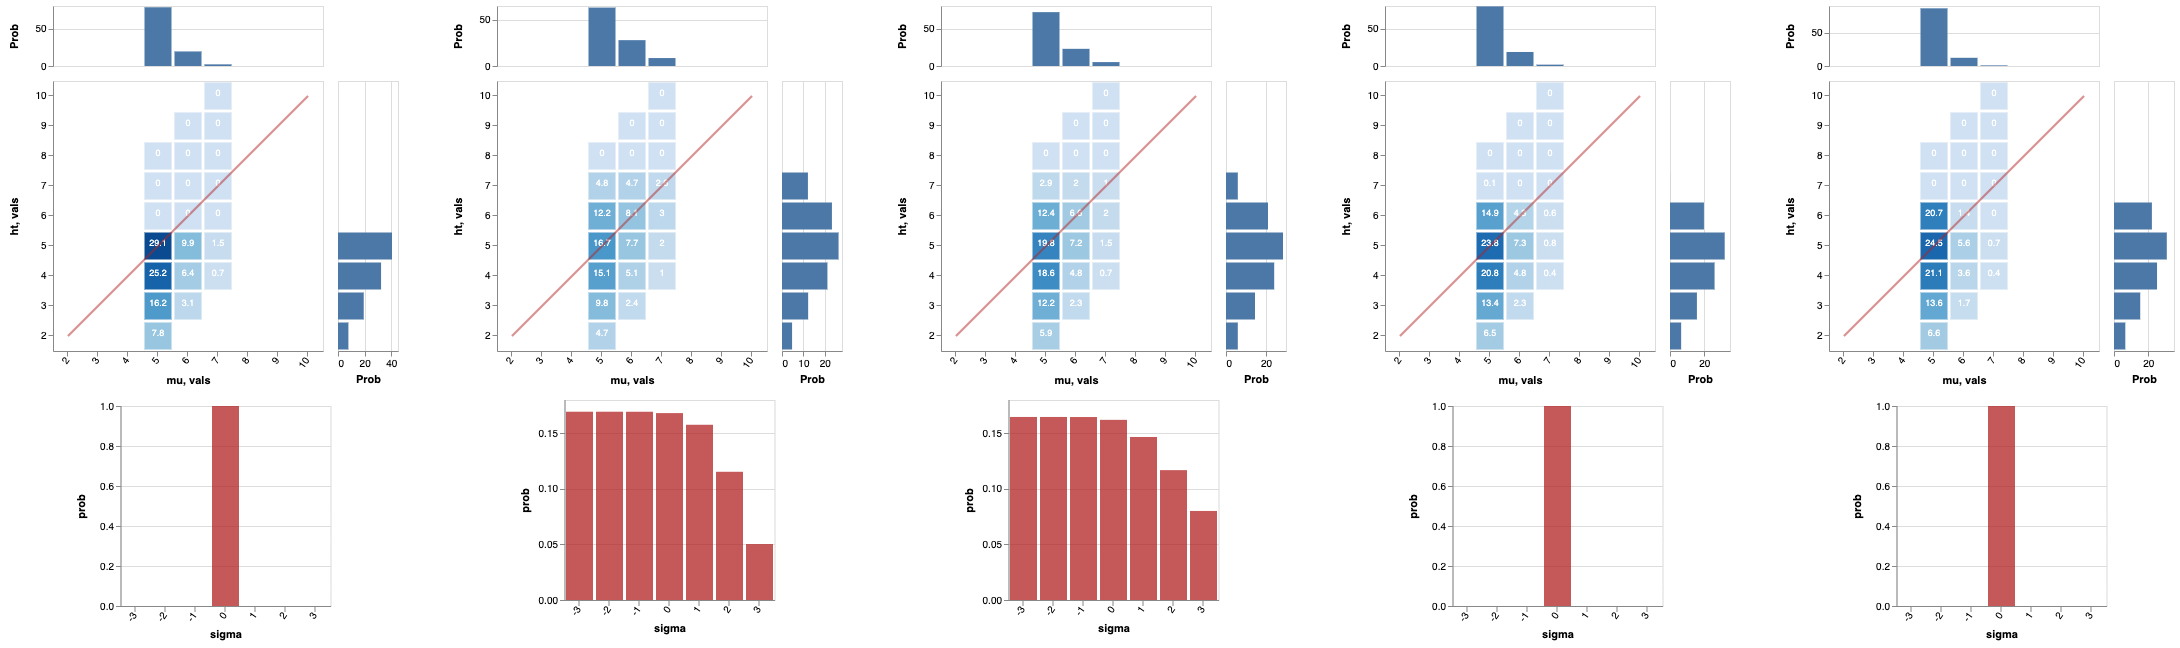

In [57]:
writeIORef cacheRef (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ listener infoLUMNonEq cacheRef (0, UTall, nonDenEq0)
  , lp infoLUMNonEq >>= \l -> listener infoLUMNonEq cacheRef (0, UTall, l)
  , listener infoLUMNonEq cacheRef (1, UTall, nonDenEq0)
  , listener infoLUMNonEq cacheRef (2, UTall, nonDenEq0)
  , listener infoLUMNonEq cacheRef (3, UTall, nonDenEq0)
  ]

#### Pragmatic listener hears:

> "John or Mary is as short as Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights.

But now, the various strengthenings lead ultimately to a pragmatic conclusion that John is almost certainly below the median (same for Mary)

As expected, the evaluative effect is much stronger

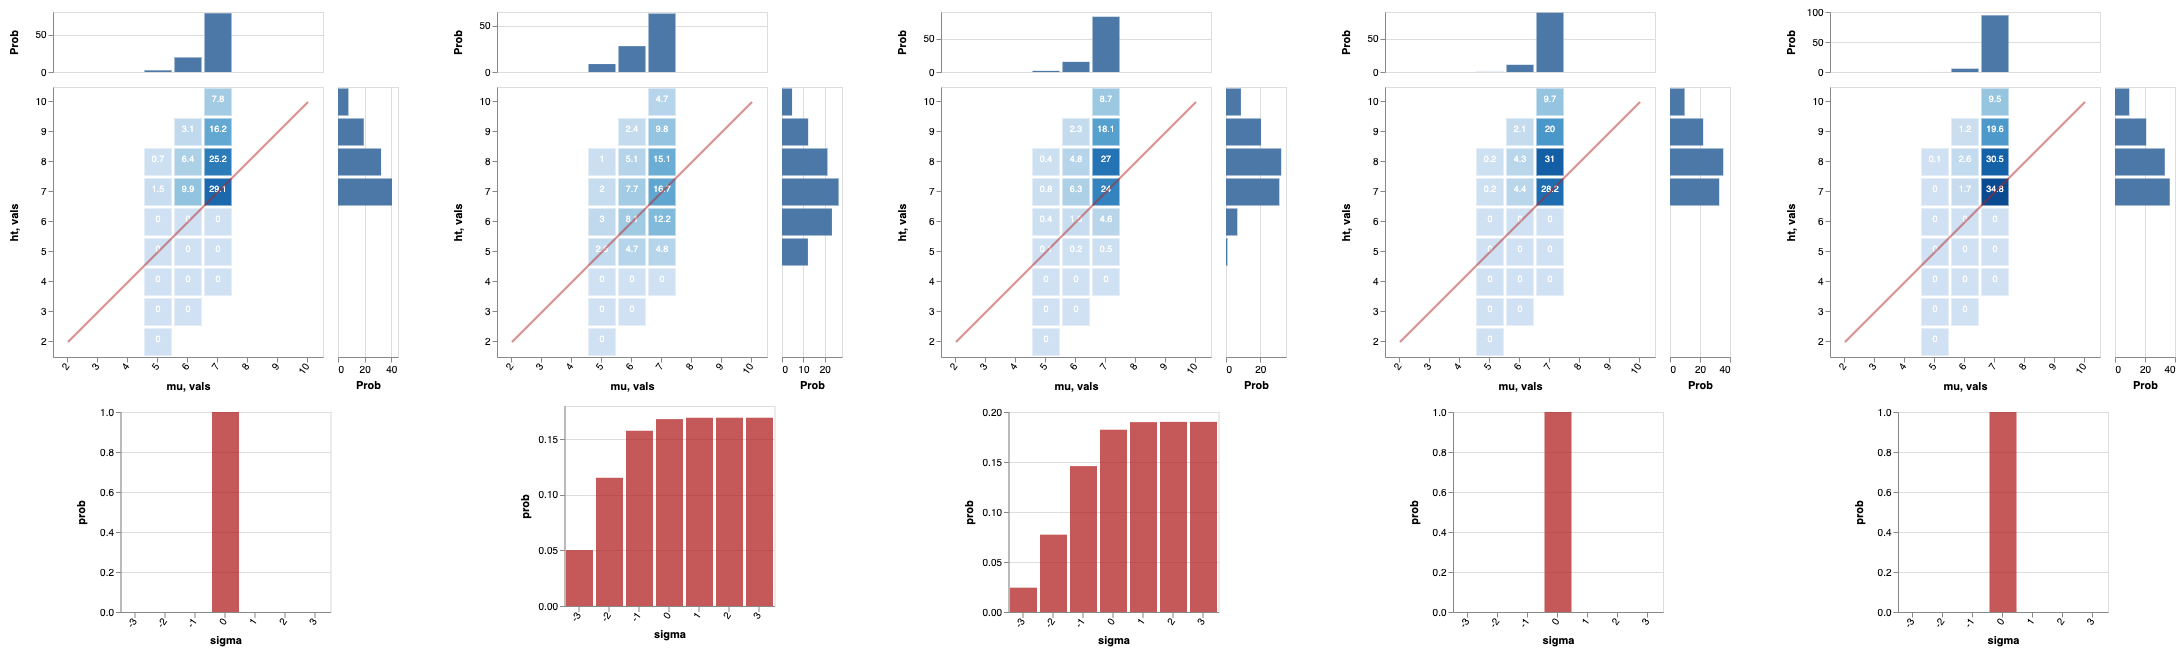

In [58]:
writeIORef cacheRef (0, Map.empty)  

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ listener infoLUMNonEq cacheRef (0, UShrt, nonDenEq0)
  , lp infoLUMNonEq >>= \l -> listener infoLUMNonEq cacheRef (0, UShrt, l)
  , listener infoLUMNonEq cacheRef (1, UShrt, nonDenEq0)
  , listener infoLUMNonEq cacheRef (2, UShrt, nonDenEq0)
  , listener infoLUMNonEq cacheRef (3, UShrt, nonDenEq0)
  ]